In [1]:
import copy
import numpy as np
import numpy.ma as ma
from scipy.io import netcdf as nc
from scipy.interpolate import griddata
from scipy import stats
import netCDF4 as nc4
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import numba
from numba import njit
import time
import sys
import altair as alt
import glob
import os
import matplotlib.animation as animation
from IPython.display import HTML

### Options

In [2]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr = 166
nlat = 46
nlon = 72

### Predefined normal functions

In [3]:
# Return harvest rate and natural PFT fraction from upscaled 4x5 harvest rate data
def retrieve_hrvrate(fpath, area_4x5, denflag=0, getmask=True, hr_lev=0.0):
    nclu=nc4.Dataset(fpath)
    prif_hv = nclu['HARVEST_VH1'][:]
    prin_hv = nclu['HARVEST_VH2'][:]
    secmf_hv = nclu['HARVEST_SH1'][:]
    secyf_hv = nclu['HARVEST_SH2'][:]
    secn_hv = nclu['HARVEST_SH3'][:]
    pct_nat_pft = nclu['PCT_NAT_PFT'][:]
    nclu.close()

    # Transfer into per m2 density value
    if(denflag == 1):
        prif_hv_den = prif_hv / (area_4x5*1e6)
        prin_hv_den = prin_hv / (area_4x5*1e6)
        secmf_hv_den = secmf_hv / (area_4x5*1e6)
        secyf_hv_den = secyf_hv / (area_4x5*1e6)
        secn_hv_den = secn_hv / (area_4x5*1e6)

        # Aggregate the number to certain year
        luh2_pri_hv = np.sum(prif_hv_den[:, :, :], 0) + np.sum(prin_hv_den[:, :, :], 0)
        luh2_sec_m_hv = np.sum(secmf_hv_den[:, :, :], 0)
        luh2_sec_y_hv = np.sum(secyf_hv_den[:, :, :], 0) + np.sum(secn_hv_den[:, :, :], 0)
        luh2_tot_hv = luh2_pri_hv + luh2_pri_hv + luh2_sec_y_hv
    else:   
        # Aggregate the harvest amount
        luh2_pri_hv = prif_hv + prin_hv
        luh2_sec_m_hv = secmf_hv
        luh2_sec_y_hv = secyf_hv + secn_hv
        luh2_tot_hv = prif_hv + prin_hv + secmf_hv + secyf_hv + secn_hv

    if(getmask):
        # mask value 1.0 represents nan
        pri_mask = copy.deepcopy(luh2_pri_hv)
        pri_mask[pri_mask>hr_lev] = -1.0
        pri_mask = pri_mask + 1.0
        luh2_pri_hv.mask = pri_mask
    
        secm_mask = copy.deepcopy(luh2_sec_m_hv)
        secm_mask[secm_mask>hr_lev] = -1.0
        secm_mask = secm_mask + 1.0
        luh2_sec_m_hv.mask = secm_mask
    
        secy_mask = copy.deepcopy(luh2_sec_y_hv)
        secy_mask[secy_mask>hr_lev] = -1.0
        secy_mask = secy_mask + 1.0
        luh2_sec_y_hv.mask = secy_mask
    
        tothrv_mask = copy.deepcopy(luh2_tot_hv)
        tothrv_mask[tothrv_mask>hr_lev] = -1.0
        tothrv_mask = tothrv_mask + 1.0
        luh2_tot_hv.mask = tothrv_mask

    # Crop and bareground fraction
    pct_crop = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),15,:,:])
    pct_bg = copy.deepcopy(pct_nat_pft[(yr_beg-1700):(yr_beg-1700+nyr),0,:,:])
    pct_nat = 100.0 - pct_crop - pct_bg
    
    return luh2_pri_hv, luh2_sec_m_hv, luh2_sec_y_hv, luh2_tot_hv, pct_nat

# Only retreive secondary forest area time series
# Can return the secondary forest fraction and grid area time series if set verbose_output to True
def retrieve_secfrac_luh2(fpath, verbose_output=False):
    nclu=nc4.Dataset(fpath)
    secf_luh2 = nclu['secdf'][:]
    secn_luh2 = nclu['secdn'][:]
    lat_luh2 = nclu['lat'][:]
    lon_luh2 = nclu['lon'][:]
    nclu.close()

    # Global grid area for 0.25 deg for LUH2 datasets
    nlon_loc = 1440
    nlat_loc = 720
    grid_area = np.ones((nlat_loc, nlon_loc))*-9999.
    earth_area = 5.096e14
    lat = np.arange(-89.875, 90.125, 0.25)
    res = 0.25;
    for i in np.arange(0,nlat_loc):
        for j in np.arange(0,nlon_loc):
            grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                        np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
    
    sec_tot = secf_luh2+secn_luh2
    sec_tot[secf_luh2<=0.0] = np.float('nan')
    seca_luh2 = copy.deepcopy(sec_tot[(1165-nyr):1165,:,:])
    for i in np.arange(0,nyr):
        seca_luh2[i,:,:] = sec_tot[(1165-nyr+i),:,:] * grid_area
    # m2 to km2
    seca_luh2_tot = np.nansum(np.nansum(seca_luh2, 1), 1)/1e6
    
    if(verbose_output):
        return seca_luh2_tot, sec_tot, grid_area
    else:
        return seca_luh2_tot

def plot_all_cases(modname, sel_yr, varlist, set_levels, set_ticks, set_unit_tag, save_path, savefig = False):
    # Plot 4 x 3
    # Define the figure and each axis for the 4 rows and 3 columns
    fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(24,16))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    # Subplot of all cases 
    for i in np.arange(0, len(modname)):
        # Contour plot
        cs=axs[i].contourf(lonnc, latnc, varlist[i][:,:], levels=set_levels, \
                       transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(modname[i], fontsize=32)

        # Draw the coastines for each subplot
        axs[i].coastlines()
    
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
        gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', spacing='proportional', 
                  extend='both', ticks = set_ticks)
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.05, 0.1, set_unit_tag, fontsize=28)
    # plt.tight_layout()
    if(savefig):
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
    
def plot_logging_cases(modname, sel_yr, varlist, set_levels, set_ticks, set_unit_tag, save_path, savefig = False):
    # Plot 2 x 4
    # Define the figure and each axis for the 4 rows and 3 columns
    fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,20))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    # Subplot of all cases 
    for i in np.arange(0, len(modname)):
        # Contour plot
        cs=axs[i].contourf(lonnc, latnc, varlist[i][:,:], levels=set_levels, \
                       transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(modname[i], fontsize=32)

        # Draw the coastines for each subplot
        axs[i].coastlines()
    
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = ticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
        gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60, 90])
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(-60,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', spacing='proportional', 
                  extend='both', ticks = set_ticks)
#     cbar.set_ticklabels(['-1%', '-0.75%', '-0.5%', '-0.25%', '0', '0.25%', '0.5%', '0.75%', '1%'])
    cbar.ax.tick_params(labelsize=20)
    fig.text(0.05, 0.1, set_unit_tag, fontsize=28)
    # plt.tight_layout()
    if(savefig):
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
    return [fig, axs]

# Obtain the logging impact either in the original unit or in the percentage
# Weights shall be multiplied with the corresponding variables before calling 
# and shall be divided by the return value (if in the original unit) after 
# calling the function. 
def obtain_logging_impact(modname, varlist, sel_yr, output_ratio = False):
    var_diff = []
    var_logging_global = []
    var_diff_deno = []
    var_logging_global_deno = []
    for i in np.arange(0, case_len):
        # Contour plot
        count = len(sel_yr)
        if (count > 1):
            begidx = sel_yr[0]
            endidx = sel_yr[count - 1]
            if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
                if(modname[i][4:5] == 'c'):
                    if(modname[i] != 'har_c'):
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[i+1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
                    else:
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
                else:
                    if(modname[i][4:5] == 'a'):
                        var_diff.append(np.nanmean(varlist[i][begidx:endidx,:,:] - varlist[i-1][begidx:endidx,:,:], 0))
                        var_diff_deno.append(np.nanmean(varlist[i][begidx:endidx,:,:], 0))
        else:
            if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
                if(modname[i][4:5] == 'c'):
                    if(modname[i] != 'har_c'):
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[i+1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
                    else:
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
                else:
                    if(modname[i][4:5] == 'a'):
                        var_diff.append(varlist[i][sel_yr[0],:,:] - varlist[i-1][sel_yr[0],:,:])
                        var_diff_deno.append(varlist[i][sel_yr[0],:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_diff[i], 0), 0))
        var_logging_global_deno.append(np.nanmean(np.nanmean(var_diff_deno[i], 0), 0))
    if(output_ratio):
        global_total = 100.0 * np.array(var_logging_global)/np.array(var_logging_global_deno)
    else:
        global_total = np.array(var_logging_global)
    return [var_diff, global_total]

def obtain_logging_impact_ts(modname, varlist):
    var_logging = []
    var_logging_global = []
    for i in np.arange(0, case_len):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                var_logging.append(varlist[i][:,:,:] - varlist[i+1][:,:,:])
            else:
                var_logging.append(varlist[i][:,:,:] - varlist[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                var_logging.append(varlist[i][:,:,:] - varlist[i-1][:,:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_logging[i][:,:,:], 1), 1))
    return [var_logging, var_logging_global]

# Direct impact is calculated by subtracting the variable values after logging (Feb) from before the logging (Jan) 
def obtain_dir_logging_impact_ts(modname, varlist, begyr, endyr):
    var_logging = []
    var_logging_global = []
    begidx_aft = 12*begyr+1
    endidx_aft = 12*endyr+1
    begidx_bef = 12*begyr
    endidx_bef = 12*endyr
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                var_logging.append(varlist[i][:,:,:] - varlist[i+1][:,:,:])
            else:
                var_logging.append(varlist[i][:,:,:] - varlist[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                var_logging.append(varlist[i][:,:,:] - varlist[i-1][:,:,:])
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            var_logging.append(varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:])        
    for i in np.arange(0, len(modname_hrv)):
        var_logging_global.append(np.nanmean(np.nanmean(var_logging[i], 1), 1))
    return [var_logging, var_logging_global]

# Change of variables due to natural + CO2 fertilization
# Can accept either a consecutive sequence of months [begmonth, endmonth] or a single month
def obtain_regrowth_ts(modname, varlist, begyr, endyr, months):
    var_regrowth = []
    var_regrowth_global = []
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            begidx_bef = 12*begyr+months[0]-1
            endidx_bef = 12*endyr+months[0]-1
            if(len(months) > 1):
                # Multiple months
                begidx_aft = 12*begyr+months[1]-1
                endidx_aft = 12*endyr+months[1]-1    
            else:
                # One month
                begidx_aft = 12*begyr+months[0]
                endidx_aft = 12*endyr+months[0]
            var_regrowth.append(varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:])        
    for i in np.arange(0, len(modname_hrv)):
        var_regrowth_global.append(np.nanmean(np.nanmean(var_regrowth[i], 1), 1))
    return [var_regrowth, var_regrowth_global]

# Regrowth from natural revovery by excluding CO2 fertilization
# The difference of Next Jan - Current Feb between with logging and without logging 
def obtain_regrowth_impact_ts(modname, varlist, begyr, endyr):
    var_regrowth = []
    var_regrowth_global = []
    var_diff_dec_jan = []
    # First calculate diff between Feb and next Jan
    begidx_bef = 12*begyr+1
    endidx_bef = 12*(endyr-1)+1
    begidx_aft = 12*begyr+12
    endidx_aft = 12*endyr
    for i in np.arange(0,case_len):
        var_diff_dec_jan.append(varlist[i][begidx_aft:endidx_aft:12,:,:] - varlist[i][begidx_bef:endidx_bef:12,:,:])  
    # Difference between with and without logging
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[i+1][:,:,:])
            else:
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                var_regrowth.append(var_diff_dec_jan[i][:,:,:] - var_diff_dec_jan[i-1][:,:,:])
    for i in np.arange(0, len(modname_hrv)):
        var_regrowth_global.append(np.nanmean(np.nanmean(var_regrowth[i], 1), 1))
    return [var_regrowth, var_regrowth_global]
        
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


### Predefined numba functions

In [4]:
# apply a mask timeseries to the timeseries with the same dimension
# ts - [array] timeseries (list_len * year * lat * lon)
# mts - [array] timeseries of the mask, same dimension as ts
# ts_dim - [array, 3*1] size of ts, time * lon * lat 
# fdir - [scalar] the direction of filter (0 - less equal; 1 - larger equal)
@njit
def apply_mask_ts(ts, mts, ts_dim, fdir, thold=0.0):
    time_len = ts_dim[0]
    lat_len = ts_dim[1]
    lon_len = ts_dim[2]
    for iyr in np.arange(0, time_len):
        for j in np.arange(0, lat_len):
            for k in np.arange(0, lon_len):
                if(fdir == 0):
                    if(mts[iyr,j,k]<= thold):
                        ts[iyr,j,k] = np.nan
                else:
                    if(mts[iyr,j,k]>= thold):
                        ts[iyr,j,k] = np.nan
    return ts

### Use NetCDF4 to open dataset

In [33]:
## Get and open the history file
## Change the line below to point to the file that you've made,
start = time.time()

## Should be a concatenated monthly FATES history files into a single file
# filename_in = 'fates.nor_spinup.elm.h0.1850_2000.nc'
# Global variables and switches
modname = ['his_c', 'his_n', 'his_a', 'hlo_c', 'hlo_n', 'hlo_a', 'hhi_c', 'hhi_n', 'hhi_a', 'har_c']
modname_hrv = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
plot_case_list = modname_hrv
case_len = len(modname)
verbose = True
make_movie = False

# Declare blank lists
fates_area_frac = []
ref_sr = []
ref_sr_d = []
ref_sr_i = []
abs_sr = []
tot_sr = []
tot_sr_d = []
tot_sr_i = []
tot_sh = []
tot_gh = []
veg_sh = []
gro_sh = []
tot_lh = []
trans = []
c_evap = []
g_evap = []
soilc = []
vegc = []
litterc = []
vegc_pf = []
area_plants = []
structc = []
nonstructc = []
leafc = []
gpp = []
gpp_sec = []
gpp_pf = []
npp = []
nep = []
hr = []
litc_in = []
litc_out = []
np_pf = []
np_sz = []
recru_pf = []
sg = []
cr_area_pf = []
cr_area_cl = []
ca_area_ap = []
age_mort = []
back_mort = []
starv_mort = []
fire_mort = []
freeze_mort = []
hydra_mort = []
impact_mort = []
logging_mort = []
scene_mort = []
termi_mort = []
area_pf_nocomp = []
sec_frac = []
sec_biomass = []
canopy_area_ap = []
parea_ap = []
pfarea = []
hrvc = []
hrv_debt = []
hrv_debt_sec_m = []
hrv_debt_sec_y = []
tbot = []
hite = []
ca_frac = []
rad_err = []
elai = []
tlai = []

for case in modname:
#     filename_in = 'D:/FATES_cases/fates.'+case+'.1850_2015.compressed.nc'
    filename_in = 'D:/FATES_cases/fates.'+case+'.1850_2015.compressed.nc'
    
    # Loop over multiple model Monthly mean output
    ds = nc4.Dataset(filename_in)
    
    ## read in variables
    ## Climate
    tbot.append(ds['TBOT'][:])
    
    fates_area_frac.append(ds['FATES_FRACTION'][:])
    ## Biogeophysics
    ref_sr.append(ds['FSR'][:])
    ref_sr_d.append(ds['FSRVD'][:])
    ref_sr_i.append(ds['FSRVI'][:])
    abs_sr.append(ds['FSA'][:])
    tot_sr.append(ds['FSDS'][:])
    tot_sr_d.append(ds['FSDSVD'][:])
    tot_sr_i.append(ds['FSDSVI'][:])
    tot_sh.append(ds['FSH'][:])
    rad_err.append(ds['FATES_RAD_ERROR'][:])
#     veg_sh.append(ds['FSH_V'][:])
#     gro_sh.append(ds['FSH_G'][:])
    tot_lh.append(ds['EFLX_LH_TOT'][:])
#     trans.append(ds['FCTR'][:])
#     c_evap.append(ds['FCEV'][:])
#     g_evap.append(ds['FGEV'][:])
    tot_gh.append(ds['FGR'][:])
    
    ## Macro-ecology
#     soilc.append(ds['SOILC'][:])
    vegc.append(ds['FATES_VEGC'][:])
#     litterc.append(ds['LITTERC'][:])
#     vegc_pf.append(ds['FATES_VEGC_PF'][:])
#     area_plants.append(ds['FATES_AREA_PLANTS'][:])
#     structc.append(ds['FATES_STRUCTC'][:])
#     nonstructc.append(ds['FATES_NONSTRUCTC'][:])
#     leafc.append(ds['FATES_LEAFC'][:])
    
    # C fluxes
    gpp.append(ds['FATES_GPP'][:])
    gpp_sec.append(ds['FATES_GPP_SECONDARY'][:])
    gpp_pf.append(ds['FATES_GPP_PF'][:])
#     npp.append(ds['FATES_NPP'][:])
#     nep.append(ds['FATES_NEP'][:])
#     # nbp = ds['NBP'][:]
#     hr.append(ds['FATES_HET_RESP'][:])
#     litc_in.append(ds['FATES_LITTER_IN'][:])
#     litc_out.append(ds['FATES_LITTER_OUT'][:])
    
#     ## Micro-ecology
#     # Nplant
#     np_pf.append(ds['FATES_NPLANT_PF'][:])
#     np_sz.append(ds['FATES_NPLANT_SZ'][:])

#     # Recruitment
#     recru_pf.append(ds['FATES_RECRUITMENT_PF'][:])

#     # Germinated Seed
#     sg.append(ds['FATES_SEED_GERM_EL'][:])

    # Crown area to calculate dominant PFT
    cr_area_pf.append(ds['FATES_CROWNAREA_PF'][:])
    ca_area_ap.append(ds['FATES_CANOPYAREA_AP'][:])
    cr_area_cl.append(ds['FATES_CROWNAREA_CL'][:])
    hite.append(ds['FATES_CA_WEIGHTED_HEIGHT'][:])
    elai.append(ds['ELAI'][:])
    tlai.append(ds['TLAI'][:])
    
#     # Mortality (Commneted mortalities are all zeros)
#     # Requires huge memory
#     # Do not read if not necessary
#     age_mort.append(ds['FATES_MORTALITY_AGESCEN_SZ'][:])
#     back_mort.append(ds['FATES_MORTALITY_BACKGROUND_SZ'][:])
#     starv_mort.append(ds['FATES_MORTALITY_CSTARV_SZ'][:])
#     # fire_mort.append(ds['FATES_MORTALITY_FIRE_SZ'][:])
#     freeze_mort.append(ds['FATES_MORTALITY_FREEZING_SZ'][:])
#     hydra_mort.append(ds['FATES_MORTALITY_HYDRAULIC_SZ'][:])
#     # impact_mort.append(ds['FATES_MORTALITY_IMPACT_SZ'][:])
#     logging_mort.append(ds['FATES_MORTALITY_LOGGING_SZ'][:])
#     scene_mort.append(ds['FATES_MORTALITY_SENESCENCE_SZ'][:])
#     # termi_mort.append(ds['FATES_MORTALITY_TERMINATION_SZ'][:])

    # No-comp mode only, please comment this out if not no-comp mode result
    area_pf_nocomp.append(ds['FATES_NOCOMP_PATCHAREA_PF'][:])
    
    # LUC related
    # # Requires huge memory
    # # Do not read if not necessary
    # hrvflux = ds['FATES_HARVEST_CARBON_FLUX'][:]
    # # prod10c = ds['PROD10C'][:]
    # # prod100c = ds['PROD100C'][:]
    # # hrv10flux = ds['HRV_DEADSTEMC_TO_PROD10C'][:]
    # hrv100flux = ds['HRV_DEADSTEMC_TO_PROD100C'][:]
    hrvc.append(ds['FATES_WOOD_PRODUCT'][:])
    hrv_debt.append(ds['FATES_HARVEST_DEBT'][:])
    hrv_debt_sec_m.append(ds['FATES_HARVEST_DEBT_SEC_MATURE'][:])
    hrv_debt_sec_y.append(ds['FATES_HARVEST_DEBT_SEC_YOUNG'][:])

    # Secondary forest related (fraction and age distribution)
    sec_frac.append(ds['FATES_SECONDARY_FOREST_FRACTION'][:])
    sec_biomass.append(ds['FATES_VEGC_SE_PF'][:])
    canopy_area_ap.append(ds['FATES_CANOPYAREA_AP'][:])
    parea_ap.append(ds['FATES_PATCHAREA_AP'][:])
    pfarea.append(ds['FATES_NOCOMP_PATCHAREA_PF'][:])
    
    ds.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc

end = time.time()

print('Time elapsed: ', end - start)


('Time elapsed: ', 147.47399997711182)


In [21]:
# Tropical/extra-tropical only masks through replacing land_4x5
land_4x5_trop = copy.deepcopy(land_4x5)
land_4x5_extrop = copy.deepcopy(land_4x5)
land_4x5_trop[0:15,:] = 0.0
land_4x5_trop[32:46,:] = 0.0
land_4x5_extrop[16:32,:] = 0.0

In [24]:
# Check all gridcells with a canopy coverage decrease larger than 10% under no harvest simulation
# These outliers shall be removed when calculating the BGP effect due to certain issues with FATES global simualtions.
cr_area_1850s = []
cr_area_2000s = []
cr_area_yr = np.zeros((nyr, 46, 72))
for i in np.arange(0,case_len):
    for iyr in np.arange(0,nyr):
        # canopy coverage
        cr_area_yr[iyr,:,:] = np.nanmean(cr_area_cl[i][12*iyr:12*iyr+12,0,:,:], 0)
    cr_area_1850s.append(np.nanmean(cr_area_yr[0:10,:,:], 0))
    cr_area_2000s.append(np.nanmean(cr_area_yr[nyr-10:nyr,:,:], 0))
cr_area_diff_his_c = cr_area_1850s[0] - cr_area_2000s[0]
cr_area_diff_his = cr_area_1850s[1] - cr_area_2000s[1]
cr_area_diff_his_a = cr_area_1850s[2] - cr_area_2000s[2]
cr_area_diff_hlo_c = cr_area_1850s[3] - cr_area_2000s[3]
cr_area_diff_hlo = cr_area_1850s[4] - cr_area_2000s[4]
cr_area_diff_hlo_a = cr_area_1850s[5] - cr_area_2000s[5]
cr_area_diff_hhi_c = cr_area_1850s[6] - cr_area_2000s[6]
cr_area_diff_hhi = cr_area_1850s[7] - cr_area_2000s[7]
cr_area_diff_hhi_a = cr_area_1850s[8] - cr_area_2000s[8]
outliers_his_c = np.where(cr_area_diff_his_c > 0.5)
outliers_his = np.where(cr_area_diff_his > 0.1)
outliers_his_a = np.where(cr_area_diff_his_a > 0.5)
outliers_hlo_c = np.where(cr_area_diff_hlo > 0.5)
outliers_hlo = np.where(cr_area_diff_hlo > 0.1)
outliers_hlo_a = np.where(cr_area_diff_hlo > 0.5)
outliers_hhi_c = np.where(cr_area_diff_hhi > 0.5)
outliers_hhi = np.where(cr_area_diff_hhi > 0.1)
outliers_hhi_a = np.where(cr_area_diff_hhi > 0.5)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value

### Read in original LUH2 states

In [ ]:
start = time.time()

if(verbose):
    # Open LUH2 states dataset
    fpath = 'C:/Users/sshu3/anaconda_wkspace/states.nc'
    seca_luh2_tot = retrieve_secfrac_luh2(fpath, verbose_output=False)

    fpath = 'D:/LUH2/states_hist_lo.nc'
    seca_luh2_lo_tot = retrieve_secfrac_luh2(fpath, verbose_output=False)

    fpath = 'D:/LUH2/states_hist_hi.nc'
    seca_luh2_hi_tot = retrieve_secfrac_luh2(fpath, verbose_output=False)

    # Plot secondary forest fraction (if sec_tot is available)
    # Secondary forest area map from LUH2 (in fraction, not necessary)
    # Require verbose output from function (retrieve_secfrac_luh2)
    if(False):
        sec_tot = secf_luh2+secn_luh2
        sec_tot[secf_luh2<=0.0] = np.float('nan')

        fig = plt.figure(figsize=(10,10), dpi=300)
        ax = plt.axes(projection=ccrs.PlateCarree())
        cs = plt.contourf(lon_luh2, lat_luh2, secf_luh2[1165,:,:]+sec_tot[1165,:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
        ax.coastlines()

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.xformatter = LONGITUDE_FORMATTER

        gl.yformatter = LATITUDE_FORMATTER
        fig.text(0.15, 0.37, 'LUH2 baseline - Global Secondary forest area fraction (0-1)', fontsize=16)
        fig.text(0.25, 0.22, 'Secondary forest fraction, 2015 (0-1)', fontsize=24)
        cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
        plt.show()
        # plt.savefig('SEC_VEGFRAC_LUH2.png')
        
end = time.time()

print('Time elapsed: ', end - start)

### Read in upscaled LUH2 harvest rate data

In [23]:
# Open dataset
# Comment: "retrieve_hrvrate" will obtain masked arrays by default.
# You can either set option get_mask=False to obtain normal numpy array 
# Or avoid to mix the calculation with other masked arrays
fpath = 'C:/Users/sshu3/anaconda_wkspace/Fates/landuse_timeseries/landuse.timeseries_4x5_hist_harmonized_simyr1700-2015.biomass_harvest.nc'
[luh2_pri_hv, luh2_sec_m_hv, luh2_sec_y_hv, luh2_tot_hv, pct_nat] = retrieve_hrvrate(fpath, area_4x5, 0, True, 0.0)

fpath = 'C:/Users/sshu3/anaconda_wkspace/Fates/landuse_timeseries/landuse.timeseries_4x5_HIST_simyr1700-2015.biomass_harvest.nc'
[luh2_pri_hv_his, luh2_sec_m_hv_his, luh2_sec_y_hv_his, luh2_tot_hv_his, pct_nat_his] = retrieve_hrvrate(fpath, area_4x5, 0, True, 0.0)

fpath = 'C:/Users/sshu3/anaconda_wkspace/Fates/landuse_timeseries/landuse.timeseries_4x5_HIST_lo_simyr1700-2015.biomass_harvest.nc'
[luh2_pri_hv_lo, luh2_sec_m_hv_lo, luh2_sec_y_hv_lo, luh2_tot_hv_lo, pct_nat_lo] = retrieve_hrvrate(fpath, area_4x5, 0, True, 0.0)

fpath = 'C:/Users/sshu3/anaconda_wkspace/Fates/landuse_timeseries/landuse.timeseries_4x5_HIST_hi_simyr1700-2015.biomass_harvest.nc'
[luh2_pri_hv_hi, luh2_sec_m_hv_hi, luh2_sec_y_hv_hi, luh2_tot_hv_hi, pct_nat_hi] = retrieve_hrvrate(fpath, area_4x5, 0, True, 0.0)

# Shall not create mask for n cases, which will cause trouble when calculating diffs.
mask_list = []
for case in modname:
    if(case[0:3] == 'his'):
        if(case[4] == 'n'):
            mask_list.append(np.zeros(np.shape(luh2_tot_hv_his.mask)))
        else:
            mask_list.append(copy.deepcopy(luh2_tot_hv_his.mask))
    elif (case[0:3] == 'hlo'):
        if(case[4] == 'n'):
            mask_list.append(np.zeros(np.shape(luh2_tot_hv_his.mask)))
        else:
            mask_list.append(copy.deepcopy(luh2_tot_hv_lo.mask))
    elif (case[0:3] == 'hhi'):
        if(case[4] == 'n'):
            mask_list.append(np.zeros(np.shape(luh2_tot_hv_his.mask)))
        else:
            mask_list.append(copy.deepcopy(luh2_tot_hv_hi.mask))
    elif (case[0:3] == 'har'):
        if(case[4] == 'n'):
            mask_list.append(np.zeros(np.shape(luh2_tot_hv_his.mask)))
        else:
            mask_list.append(copy.deepcopy(luh2_tot_hv.mask))

annual_hrv_debt = []
hrv_debt_yr = np.zeros((nyr, 46, 72))
# # Use harvest debt to filter out some gridcells which is not harvested due to small forest inventory
# # Note: harvest debt is the sum of debt from all categories. It is highly possible that one harvest 
# # category has debt but another one does not. Thus using harvest debt to filter out gridcell is not
# # reasonable
# for i in np.arange(0,case_len):
#     for iyr in np.arange(0,nyr):
#         hrv_debt_yr[iyr, :, :] = np.nanmean(hrv_debt[i][12*iyr:12*iyr+12,:,:], 0)
#     annual_hrv_debt.append(hrv_debt_yr)

# # Use actual harvested amount to filter out some gridcells which is not harvested
# for i in np.arange(0,case_len):
#     pp = hrvc[i]
#     pp[pp>1e10] = np.nan
#     for iyr in np.arange(1,nyr):
#         hrv_debt_yr[iyr, :, :] = (hrvc[i][12*iyr-1,:,:]-hrvc[i][12*iyr-13,:,:])*area_4x5*1e6
#     annual_hrv_debt.append(hrv_debt_yr)

# Use actual harvested fraction (harvested C/forest inventory C) to filter out some gridcells which is not harvested        
for i in np.arange(0,case_len):
    pp = hrvc[i]
    qq = vegc[i]
    pp[pp>1e10] = np.nan
    qq[qq>1e10] = np.nan
    for iyr in np.arange(2,nyr):
        hrv_debt_yr[iyr, :, :] = (pp[12*iyr-1,:,:]-pp[12*iyr-13,:,:])/(qq[12*iyr-1,:,:]+1e-5)
    annual_hrv_debt.append(hrv_debt_yr)

# Change masks by checking annual_hrv_debt
for i in np.arange(0,case_len):
    tmp = mask_list[i]
    tmp_hrv = annual_hrv_debt[i]
    for iyr in np.arange(2,nyr):
        tmp_in = tmp[(yr_beg-1700+iyr),:,:]
        tmp_hrv_in = tmp_hrv[iyr,:,:]
        tmp_in[tmp_hrv_in < 1e-6] = 1.0

# Perform 
# # Need a unified mask for all cases?
# umask = luh2_tot_hv_his.mask & luh2_tot_hv_lo.mask & luh2_tot_hv_hi.mask & luh2_tot_hv.mask

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in less


In [ ]:
if(verbose):
    # Validate if the mask is working properly
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, mask_list[9][165,:,:], 60, levels=np.linspace(0.0, 1.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
    fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0] )
    plt.show()

In [ ]:
if(verbose):
    # Validate if the mask is working properly
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, mask_list[9][165,:,:], 60, levels=np.linspace(0.0, 1.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
    fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0] )
    plt.show()

### Make plots (secondary forest area)

In [ ]:
# Plot the spatial distribution at the selected year
sel_yr = nyr
sec_frac_plot = []
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        sec_frac_sel = copy.deepcopy(sec_frac[i][12*sel_yr-1,:,:])
        sec_frac_sel[sec_frac_sel<=0] = np.float('nan')
        fates_area_frac_sel = copy.deepcopy(fates_area_frac[i][12*sel_yr-1,:,:])
        pfarea_sel = copy.deepcopy(pfarea[i][12*sel_yr-1,0:9,:,:])
        pct_nat_sel = 0.01 * copy.deepcopy(pct_nat[sel_yr-1,:,:])
        sec_frac_sel = sec_frac_sel * fates_area_frac_sel * land_4x5 #* np.nansum(pfarea_sel, 0) * pct_nat_sel
        sec_frac_plot.append(sec_frac_sel)
    
# Other options for plot
set_levels = np.linspace(0, 1, 101)
set_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
set_unit_tag = ''
save_path = './sec_forest_frac_2015.png'    
# Plot albedo change by logging activity for all cases
plot_logging_cases(modname_hrv, sel_yr, sec_frac_plot, set_levels, set_ticks, set_unit_tag, save_path, savefig = True)

In [ ]:
# Calculate the time series of global secondary forest area 
fig = plt.figure(figsize=(6,6), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)
case_hrv_len = len(modname_hrv)
modname_hrv = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']

seca_fates_tot = []
# Fraction from each model
for imod in np.arange(0,case_len):
    # No harv cases are excluded
    if(modname[imod][4:5] == 'c' or modname[imod][4:5] == 'a'):
        seca_fates = copy.deepcopy(sec_frac[imod][0:nyr,:,:])
        # Secondary forest area from FATES
        # area_4x5 --- grid area
        # land_4x5 --- land mask
        # fates_area_frac --- area fraction accounted for in FATES 
        # 0.01 * pct_nat --- fraction of area after excluding crop and bareground
        # pfarea --- fraction of area for each FATES PFT, to exclude grassland
        for i in np.arange(0,nyr):
            # seca_fates[i,:,:] = sec_frac[12*i,:,:]*area_4x5*land_4x5*fates_area_frac[12*i,:,:]*0.01*pct_nat[i,:,:]*np.nansum(pfarea[12*i,0:6,:,:], 0)
            # Another equation considering crown area only
            if (modname[imod][4:5] == 'c'):
                seca_fates[i,:,:] = sec_frac[imod][12*i,:,:]/fates_area_frac[imod][12*i,:,:]*area_4x5*land_4x5*np.nansum(pfarea[imod][12*i,0:9,:,:], 0)*np.nansum(cr_area_pf[imod][12*i,0:9,:,:], 0)*0.01*pct_nat[i,:,:]
            else:
                seca_fates[i,:,:] = sec_frac[imod][12*i,:,:]/fates_area_frac[imod][12*i,:,:]*area_4x5*land_4x5*np.nansum(pfarea[imod][12*i,0:9,:,:], 0)
        # Unit from FATES is already in km2
        seca_fates_tot.append(np.nansum(np.nansum(seca_fates, 1), 1))

# Plots
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray','k']
for imod in np.arange(0,case_hrv_len):
    plt.plot(yr_axis, seca_fates_tot[imod][:], color_list[imod])
plt.plot(yr_axis, seca_luh2_tot, color_list[case_hrv_len])

legend_list = copy.deepcopy(modname_hrv)
legend_list.append('LUH2 baseline')
plt.legend(legend_list, fontsize=9)
plt.title('Secondary forest area')
plt.ylim([0,3e7])
plt.xlabel('Year')
plt.ylabel('Total area ($km^2$)')
plt.savefig('SEC_VEGFRAC_TS.png')

### Make plots (harvested woody C)

In [ ]:
# Plot the spatial distribution of the selected year
sel_yr = nyr
hrvc_plot = []
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        hrvc_sel = copy.deepcopy(hrvc[i][12*sel_yr-1,:,:])
        hrvc_sel[hrvc_sel<=0] = np.float('nan')
        fates_area_frac_sel = copy.deepcopy(fates_area_frac[i][12*sel_yr-1,:,:])
        pfarea_sel = copy.deepcopy(pfarea[i][12*sel_yr-1,0:9,:,:])
        pct_nat_sel = 0.01 * copy.deepcopy(pct_nat[sel_yr-1,:,:])
        hrvc_sel = hrvc_sel * fates_area_frac_sel * pct_nat_sel
        hrvc_plot.append(hrvc_sel)
    
# Other options for plot
set_levels = np.linspace(0, 2, 101)
set_ticks = [0, 0.4, 0.8, 1.2, 1.6, 2.0]
# set_unit_tag = 'Unit: kgC $m^{-2}$ (land area) $yr^{-1}$'
set_unit_tag = ''
save_path = './harvested_c_2015.png'    
# Plot albedo change by logging activity for all cases
plot_logging_cases(modname_hrv, sel_yr, hrvc_plot, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)

if(verbose):
    # Harvested C from har-c case (or other specific case if change the modname)
    lonnc_new = copy.deepcopy(lonnc[0,:])
    latnc_new = copy.deepcopy(latnc[:,0])
    sel_yr = nyr
    for i in np.arange(0,len(modname)):
        if(modname[i] == 'har_c'):
            hrvc_new = copy.deepcopy(hrvc[i][12*sel_yr-1,:,:])
            hrvc_new[hrvc_new<=0] = np.float('nan')

    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc_new, latnc_new, hrvc_new[:,:], 60, levels=np.linspace(0.0, 2.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'FATES - Global harvested C', fontsize=16)
    fig.text(0.25, 0.22, 'Biomass C (kgC m-2)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 0.4, 0.8, 1.2, 1.6, 2.0] )
    plt.show()
    # plt.savefig('HRV_C_FATES.png')

In [ ]:
if(verbose):
    # Time series of harvested C for the selected case
    sel_case = 'har_c'

    # LUH2 harvested C (kgC to PgC)
    luh2_hrv_pri = np.nansum(np.nansum(luh2_pri_hv, 1), 1)*1e-12
    luh2_hrv_sec_m = np.nansum(np.nansum(luh2_sec_m_hv, 1), 1)*1e-12
    luh2_hrv_sec_y = np.nansum(np.nansum(luh2_sec_y_hv, 1), 1)*1e-12

    # Calculate the FATES estimated harvested C by subtracting harvest debt from LUH2 original data
    # Note: We did not implement the harvest debt calculation in area based method yet.
    # Initialization
    hrvc_fates_pri = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_sec_m = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_sec_y = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_pri_tot = []
    hrvc_fates_sec_m_tot = []
    hrvc_fates_sec_y_tot = []

    # Model cases
    for i in np.arange(0,len(modname)):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            for iyr in np.arange(0,nyr):
                hrvc_fates_pri[iyr,:,:] = luh2_pri_hv[yr_beg-1700+iyr,:,:] - np.nanmean((hrv_debt[i][12*iyr:12*iyr+12,:,:] - \
                             hrv_debt_sec_m[i][12*iyr:12*iyr+12,:,:] - hrv_debt_sec_y[i][12*iyr:12*iyr+12,:,:]), 0)
                hrvc_fates_sec_m[iyr,:,:] = luh2_sec_m_hv[yr_beg-1700+iyr,:,:] - np.nanmean(hrv_debt_sec_m[i][12*iyr:12*iyr+12,:,:], 0)
                hrvc_fates_sec_y[iyr,:,:] = luh2_sec_y_hv[yr_beg-1700+iyr,:,:] - np.nanmean(hrv_debt_sec_y[i][12*iyr:12*iyr+12,:,:], 0)
            # Unit from kgC to PgC
            hrvc_fates_pri_tot.append(np.nansum(np.nansum(hrvc_fates_pri, 1), 1)*1e-12)
            hrvc_fates_sec_m_tot.append(np.nansum(np.nansum(hrvc_fates_sec_m, 1), 1)*1e-12)
            hrvc_fates_sec_y_tot.append(np.nansum(np.nansum(hrvc_fates_sec_y, 1), 1)*1e-12)

    # Make plots
    fig = plt.figure(figsize=(5,5), dpi=300)
    yr_axis = yr_beg + np.arange(0,nyr)
    plt.plot(yr_axis, luh2_hrv_pri[(yr_beg-1700):(yr_beg-1700+nyr)], 'r-')
    plt.plot(yr_axis, luh2_hrv_sec_m[(yr_beg-1700):(yr_beg-1700+nyr)], 'g-')
    plt.plot(yr_axis, luh2_hrv_sec_y[(yr_beg-1700):(yr_beg-1700+nyr)], 'b-')
    for i in np.arange(0,len(modname_hrv)):
        if(modname_hrv[i] == sel_case):
            plt.plot(yr_axis, hrvc_fates_pri_tot[i], 'r--')
            plt.plot(yr_axis, hrvc_fates_sec_m_tot[i], 'g--')
            plt.plot(yr_axis, hrvc_fates_sec_y_tot[i], 'b--')

    plt.legend(['LUH2 harvested C from primay', 'LUH2 harvested C from secondary mature', 
                'LUH2 harvested C from secondary young', 'har-c harvested C from secondary mature', 
                'har-c harvested C from secondary young', 'har-c harvested C from primary'], fontsize=8)
    plt.ylim([0, 1.3])
    plt.xlabel('Year')
    plt.ylabel('Total harvested C (PgC)')
    plt.savefig('HRV_C_FATES_TS.png')

In [ ]:
## Bar chart of harvested C

# Global total of LUH2, kgC to PgC
luh2_hrv_tot = np.nansum(np.nansum(luh2_tot_hv, 1), 1)*1e-12
luh2_hrv_sec_m = np.nansum(np.nansum(luh2_sec_m_hv, 1), 1)*1e-12
luh2_hrv_sec_y = np.nansum(np.nansum(luh2_sec_y_hv, 1), 1)*1e-12
luh2_hrv_tot_lo = np.nansum(np.nansum(luh2_tot_hv_lo, 1), 1)*1e-12
luh2_hrv_sec_m_lo = np.nansum(np.nansum(luh2_sec_m_hv_lo, 1), 1)*1e-12
luh2_hrv_sec_y_lo = np.nansum(np.nansum(luh2_sec_y_hv_lo, 1), 1)*1e-12
luh2_hrv_tot_hi = np.nansum(np.nansum(luh2_tot_hv_hi, 1), 1)*1e-12
luh2_hrv_sec_m_hi = np.nansum(np.nansum(luh2_sec_m_hv_hi, 1), 1)*1e-12
luh2_hrv_sec_y_hi = np.nansum(np.nansum(luh2_sec_y_hv_hi, 1), 1)*1e-12

# FATES estimations
# We have not accounted for the harvest debt from area based harvest simulations
# So for the area based harvest we assume pri:sec_m:sec_y = 7:1.4:1.6, based on the LUH2 data
subclass = False

if(subclass):
    hrvc_fates = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_sec_m = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_sec_y = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_tot = []
    hrvc_fates_sec_m_tot = []
    hrvc_fates_sec_y_tot = []
    # Model cases
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            for iyr in np.arange(0,nyr):
                if(modname[i][4:5] == 'c'):
                    hrvc_fates[iyr,:,:] = luh2_hrv[yr_beg-1700+iyr,:,:] - hrv_debt[i][12*iyr+1,:,:]
                    hrvc_fates_sec_m[iyr,:,:] = luh2_sec_m_hv[yr_beg-1700+iyr,:,:] - hrv_debt_sec_m[i][12*iyr+1,:,:]
                    hrvc_fates_sec_y[iyr,:,:] = luh2_sec_y_hv[yr_beg-1700+iyr,:,:] - hrv_debt_sec_y[i][12*iyr+1,:,:]
                else:
                    hrvc_fates[iyr,:,:] = hrvc[i][12*iyr,:,:]*area_4x5*land_4x5*1e6*10.0/365.0
                    hrvc_fates_sec_m[iyr,:,:] = hrvc[i][12*iyr,:,:]*area_4x5*land_4x5*1e6*0.14*10.0/365.0
                    hrvc_fates_sec_y[iyr,:,:] = hrvc[i][12*iyr,:,:]*area_4x5*land_4x5*1e6*0.16*10.0/365.0
            # Unit from kgC to PgC
            hrvc_fates_tot.append(np.nansum(np.nansum(np.nansum(hrvc_fates, 1), 1), 0)*1e-12)
            hrvc_fates_sec_m_tot.append(np.nansum(np.nansum(np.nansum(hrvc_fates_sec_m, 1), 1), 0)*1e-12)
            hrvc_fates_sec_y_tot.append(np.nansum(np.nansum(np.nansum(hrvc_fates_sec_y, 1), 1))*1e-12)

    tag_list = copy.deepcopy(modname_hrv)
    tag_list.append('LUH2 baseline')

    xpos_pri = [0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 6.8, 7.8]
    xpos_secm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
    xpos_secy = [1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2]
    bval_pri = np.append(np.array(hrvc_fates_tot), np.nansum(luh2_hrv_tot[yr_beg-1700:yr_beg-1700+nyr])) - np.append(np.array(hrvc_fates_sec_m_tot), np.nansum(luh2_hrv_sec_m[yr_beg-1700:yr_beg-1700+nyr])) - np.append(np.array(hrvc_fates_sec_y_tot), np.nansum(luh2_hrv_sec_y[yr_beg-1700:yr_beg-1700+nyr]))
    bval_secm = np.append(np.array(hrvc_fates_sec_m_tot), np.nansum(luh2_hrv_sec_m[yr_beg-1700:yr_beg-1700+nyr]))
    bval_secy = np.append(np.array(hrvc_fates_sec_y_tot), np.nansum(luh2_hrv_sec_y[yr_beg-1700:yr_beg-1700+nyr]))

    plt.figure(figsize=(16,10))
    senpriplt = plt.bar(xpos_pri, bval_pri, width=0.2, align='center', color='r')
    sensecmplt = plt.bar(xpos_secm, bval_secm, width=0.2, align='center', color='g')
    sensecyplt = plt.bar(xpos_secy, bval_secy, width=0.2, align='center', color='b')
    ind = [1,2,3,4,5,6,7,8]
    plt.grid(color='gray', which='major', axis='both', alpha=0.3)
    plt.xticks(ind, tag_list, fontsize=20)
    plt.yticks([0, 20, 40, 60, 80, 100], fontsize=20)
    plt.xlim((0, 9))
    plt.ylim((0, 100))
    plt.legend(['Primary', 'Secondary Mature', 'Secondary Young'], loc='upper center', fontsize=24)
    plt.minorticks_on()
    plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
    plt.tick_params(axis='x',which='minor',bottom='off')
    plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
    plt.tick_params(axis='y',which='minor',direction='in',length=3)
    plt.tick_params(axis="x", which="major", top=True)
    plt.tick_params(axis="y", which="both", right=True)
    plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
    
else:
    hrvc_fates = copy.deepcopy(hrvc[0][0:nyr,:,:])
    hrvc_fates_tot = []
    # Model cases
    for i in np.arange(0,case_len):
        if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
            hrvc_fates_tot.append(np.nansum(np.nansum((hrvc[i][12*nyr-1,:,:]-hrvc[i][11,:,:])*area_4x5*1e6, 0), 0)*1e-12)

    tag_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c', '$LUH2_{low}$', 'LUH2', '$LUH2_{high}$']
    
    xpos_pri = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
    bval_pri = np.append(np.array(hrvc_fates_tot), [np.nansum(luh2_hrv_tot_lo[yr_beg-1700:yr_beg-1700+nyr]), 
                         np.nansum(luh2_hrv_tot[yr_beg-1700:yr_beg-1700+nyr]), np.nansum(luh2_hrv_tot_hi[yr_beg-1700:yr_beg-1700+nyr])])

    plt.figure(figsize=(16,10))
    senpriplt = plt.bar(xpos_pri, bval_pri, width=0.2, align='center', color='r')
    ind = [1,2,3,4,5,6,7,8,9,10]
    plt.grid(color='gray', which='major', axis='both', alpha=0.3)
    plt.xticks(ind, tag_list, fontsize=20)
    plt.yticks([0, 20, 40, 60, 80, 100, 120, 140, 160], fontsize=20)
    plt.xlim((0, 11))
    plt.ylim((0, 160))
    plt.legend(['Accumulated since 1850'], loc='upper center', fontsize=24)
    plt.minorticks_on()
    plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
    plt.tick_params(axis='x',which='minor',bottom='off')
    plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
    plt.tick_params(axis='y',which='minor',direction='in',length=3)
    plt.tick_params(axis="x", which="major", top=True)
    plt.tick_params(axis="y", which="both", right=True)
    plt.plot([0, 11], [0, 0], 'gray', linestyle='-.')

#plt.annotate('(a)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30)
plt.xlabel('Cases', fontsize=24)
plt.ylabel('Accumulated harvested C (1850 - 2015, PgC)', fontsize=24)
#plt.show()
plt.savefig('Harv_C.png')



### Forest age distirbution against GFAD

### Canopy area

In [ ]:
# Canopy coverage at year 2015
sel_yr = nyr
cr_sel = []
# Canopy coverage
# unit: 0 - 2 since FATES simulation is with a preset two layers
for i in np.arange(0, len(modname)):
    # Use the canopy area at different age bin
    #cr_area = np.nanmean(np.nansum(ca_area_ap[i][12*sel_yr-12:12*sel_yr,:,:,:], 1), 0)
    # Use the canopy area at first canopy layer
    cr_area = np.nanmean(cr_area_cl[i][12*sel_yr-12:12*sel_yr,0,:,:], 0)
    cr_sel.append(cr_area)

# Other options for plot
set_levels = np.linspace(0, 1, 101)
set_ticks = [0, 0.25, 0.5, 0.75, 1.0]
set_unit_tag = 'Unit: 0 - 1'
save_path = './canopy_coverage_2015.png'
# Plot albedo for all cases
plot_all_cases(modname, sel_yr, cr_sel, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)


In [ ]:
# The process producing animation may take up to 20 mins or even longer
if(make_movie):
    ndecades = 17
    cr_sel = []
    for i in np.arange(0, len(modname)):
        cr_area = np.zeros((ndecades, 46, 72))
        # Perform average for every 10 years
        for j in np.arange(0, ndecades):
            if (j<ndecades-1):
                cr_area[j,:,:] = np.nanmean(np.nansum(ca_area_ap[i][120*j:120*j+120,:,:,:], 1), 0)
            else:
                cr_area[j,:,:] = np.nanmean(np.nansum(ca_area_ap[i][120*j:np.shape(ca_area_ap)[1],:,:,:], 1), 0)           
        cr_sel.append(cr_area)
    arrays = cr_sel

    # plot function for animation, gets called for each frame
    def animate(yr):
        # Subplot of all cases 
        for i in np.arange(0, len(modname)):
            # Contour plot
            cs=axs[i].contourf(lonnc, latnc, arrays[i][yr,:,:], levels=np.linspace(0, 2, 101), \
                           transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')
        return [axs]

    # Produce animation
    anim = animation.FuncAnimation(fig, animate, frames=17, interval=1000)
    # HTML(anim.to_jshtml())
    writer = animation.PillowWriter(fps=1,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
    anim.save(filename="canopy_area.gif", writer=writer)

In [ ]:
# Will be better if I can carry out comparison against tree coverage from Landsat.
# This can be another interesting topic to look at.

In [ ]:
# Time series to show the canopy coverage over region with logging
apply_mask = True
logging_plot = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
cr_area = []
cr_area_mean = []
cr_area_logging = []
cr_area_logging_global = []

totlen = np.shape(cr_area_cl[0][:,:,:,:])[0]
for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    for iyr in np.arange(0,nyr):
        cr_area_masked_ts[iyr,:,:] = np.nanmean(cr_area_cl[i][12*iyr:12*iyr+12,0,:,:], 0)
#         cr_area_masked_ts[iyr,:,:] = np.nanmean(tot_gh[i][12*iyr:12*iyr+12,:,:], 0)
#     cr_area_masked_ts = cr_area_cl[i][:,0,:,:]
    if(apply_mask):
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
#         cr_area_masked_ts.mask=umask[(yr_beg-1700):(yr_beg-1700+nyr)]
    # Filter out nan values
    cr_area_masked_ts[cr_area_masked_ts>100.0] = np.nan
    cr_area.append(cr_area_masked_ts)
    cr_area_mean.append(np.nanmean(np.nanmean(cr_area_masked_ts, 1), 1))
    
[cr_area_logging, cr_area_logging_global] = obtain_logging_impact_ts(modname, cr_area)
# [cr_area_dir_logging, cr_area_dir_logging_global] = obtain_dir_logging_impact_ts(modname, cr_area, 0, 165)
# [cr_area_regrowth, cr_area_regrowth_global] = obtain`_regrowth_impact_ts(modname, cr_area, 0, 165)
# Another way is just calculate the regrowth impact as the difference between total logging impact and direct logging impact

if(logging_plot):
    # Plots
    color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-5)
    plt.figure(figsize=(10,8), dpi=300)
    for imod in np.arange(0, len(plot_case_list)):
        plt.plot(yr_axis, moving_average(cr_area_logging_global[imod][0:165]), color_list[imod])
    plt.legend(plot_case_list)
    plt.title('Change of canopy coverage (0 - 1)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year')
    plt.ylabel('Canopy coverage')
    plt.savefig('./canopy_coverage_ts.png')
else:
    # Plots
    color_list = ['r-', 'r*', 'r--', 'g-', 'g*', 'g--', 'b-', 'b*', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-4)
    plt.figure(figsize=(10,8))
    for imod in np.arange(0, case_len):
        plt.plot(yr_axis, moving_average(cr_area_mean[imod][:]), color_list[imod])
    plt.legend(modname)
    plt.title('Canopy coverage (0 - 2)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year since 1850')
    plt.ylabel('Canopy coverage')


In [ ]:
# Time series to show the canopy coverage over region with logging
# Here I test Feb - Jan
apply_mask = False
logging_plot = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
cr_area = []
cr_area_new = []
cr_area_mean = []
cr_area_mean_new = []
cr_area_logging = []
cr_area_logging_global = []

for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    cr_area_ts_new = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    cr_area_masked_ts_new = np.ma.masked_array(cr_area_ts_new)
    for iyr in np.arange(0,nyr):
        cr_area_masked_ts[iyr,:,:] = cr_area_cl[i][12*iyr,0,:,:]
        cr_area_masked_ts_new[iyr,:,:] = cr_area_cl[i][12*iyr+1,0,:,:]
    if(apply_mask):
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
#         cr_area_masked_ts.mask=umask[(yr_beg-1700):(yr_beg-1700+nyr)]
        cr_area_masked_ts_new.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    cr_area.append(cr_area_masked_ts)
    cr_area_new.append(cr_area_masked_ts_new)
    cr_area_mean.append(np.nanmean(np.nanmean(cr_area_masked_ts, 1), 1))
    cr_area_mean_new.append(np.nanmean(np.nanmean(cr_area_masked_ts_new, 1), 1))
    
for i in np.arange(0,case_len):
    if(modname[i][4:5] == 'c'):
        if(modname[i] != 'har_c'):
            cr_area_logging.append(cr_area_new[i][:,:,:] - cr_area[i][:,:,:])
        else:
            cr_area_logging.append(cr_area_new[i][:,:,:] - cr_area[i][:,:,:])
    else:
        if(modname[i][4:5] == 'a'):
            cr_area_logging.append(cr_area_new[i][:,:,:] - cr_area[i][:,:,:])
            
for i in np.arange(0, len(plot_case_list)):
    cr_area_logging_global.append(np.nanmean(np.nanmean(cr_area_logging[i], 1), 1))

if(logging_plot):
    # Plots
    color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-4)
    plt.figure(figsize=(10,8), dpi=300)
    for imod in np.arange(0, len(plot_case_list)):
        plt.plot(yr_axis, moving_average(cr_area_logging_global[imod][:]), color_list[imod])
    plt.legend(plot_case_list)
    plt.title('Change of canopy coverage (0 - 1)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year')
    plt.ylabel('Canopy coverage')
    plt.savefig('./canopy_coverage_ts.png')
else:
    # Plots
    color_list = ['r-', 'r*', 'r--', 'g-', 'g*', 'g--', 'b-', 'b*', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-4)
    plt.figure(figsize=(10,8))
    for imod in np.arange(0, case_len):
        plt.plot(yr_axis, moving_average(cr_area_mean[imod][:]), color_list[imod])
    plt.legend(modname)
    plt.title('Canopy coverage (0 - 2)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year since 1850')
    plt.ylabel('Canopy coverage')


In [ ]:
# Logging disturbed seasonal and diurnal change? It maybe worth discussing but 1) logging is an instant loss of forest coverage but will 
# be recovered, thus the mean state of the impact will be far less comparing to the land use change, which is a permanent modification
# of the land surface, and 2) the arbitrary logging date we appllied will largely change the results of its seasonal impact.
# Seasonal will be good to look at even we know the logging date is set to a certain month.
# Diurnal impact will be less important though, since the expected changes on the mean states are smaller.



In [35]:
# Barchart for the selected period of years
# Extra-tropics
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# All BGP responses
cr_area = []
cr_area_mean = []
alb = []
alb_mean = []
sh = []
sh_mean = []
lh = []
lh_mean = []
gh = []
gh_mean = []
abs_rad = []
abs_rad_mean = []
rlength = []
rlength_mean= []
lai = []
lai_mean = []

land_4x5_extrop_filled_nan = copy.deepcopy(land_4x5_extrop)
land_4x5_extrop_filled_nan[land_4x5_extrop_filled_nan<1e-5] = np.nan

for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    alb_ts = np.zeros((nyr, 46, 72))
    sh_ts = np.zeros((nyr, 46, 72))
    lh_ts = np.zeros((nyr, 46, 72))
    gh_ts = np.zeros((nyr, 46, 72))
    abs_ts = np.zeros((nyr, 46, 72))
    rl_ts = np.zeros((nyr, 46, 72))
    lai_ts = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    alb_masked_ts = np.ma.masked_array(alb_ts)
    sh_masked_ts = np.ma.masked_array(sh_ts)
    lh_masked_ts = np.ma.masked_array(lh_ts)
    gh_masked_ts = np.ma.masked_array(gh_ts)
    abs_masked_ts = np.ma.masked_array(abs_ts)
    rl_masked_ts = np.ma.masked_array(rl_ts)
    lai_masked_ts = np.ma.masked_array(lai_ts)
    for iyr in np.arange(0,nyr):
        # canopy coverage
        cr_area_masked_ts[iyr,:,:] = np.nanmean(cr_area_cl[i][12*iyr:12*iyr+12,0,:,:], 0)*land_4x5_extrop*area_4x5
        alb_masked_ts[iyr,:,:] = np.nanmean((ref_sr_d[i][(iyr*12):(iyr*12+12),:,:]+ref_sr_i[i][(iyr*12):(iyr*12+12),:,:]), 0)/np.nanmean((tot_sr_d[i][(iyr*12):(iyr*12+12),:,:]+tot_sr_i[i][(iyr*12):(iyr*12+12),:,:]), 0)*area_4x5*land_4x5_extrop
        sh_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_extrop_filled_nan#*area_4x5
        lh_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_extrop_filled_nan#*area_4x5
        gh_masked_ts[iyr,:,:] = np.nanmean(tot_gh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_extrop_filled_nan#*area_4x5
        abs_masked_ts[iyr,:,:] = np.nanmean(abs_sr[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_extrop_filled_nan#*area_4x5
        rl_masked_ts[iyr,:,:] = copy.deepcopy(rl[i][iyr,:,:])*land_4x5_extrop*area_4x5
        lai_masked_ts[iyr,:,:] = np.nanmean(elai[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_extrop#*area_4x5
    if(apply_mask):
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        sh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        gh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        abs_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        rl_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lai_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    # Mask out outliers due to model calculation issues
    if(i < 3 or i == 9):
        for k in np.arange(0, len(outliers_his[0])):
            idx = outliers_his[0][k]
            idy = outliers_his[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_his_c[0])):
            idx = outliers_his_c[0][k]
            idy = outliers_his_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_his_a[0])):
            idx = outliers_his_a[0][k]
            idy = outliers_his_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    if(i >= 3 and i < 6):
        for k in np.arange(0, len(outliers_hlo[0])):
            idx = outliers_hlo[0][k]
            idy = outliers_hlo[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hlo_c[0])):
            idx = outliers_hlo_c[0][k]
            idy = outliers_hlo_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hlo_a[0])):
            idx = outliers_hlo_a[0][k]
            idy = outliers_hlo_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    if(i >= 6 and i < 9):
        for k in np.arange(0, len(outliers_hhi[0])):
            idx = outliers_hhi[0][k]
            idy = outliers_hhi[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hhi_c[0])):
            idx = outliers_hhi_c[0][k]
            idy = outliers_hhi_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hhi_a[0])):
            idx = outliers_hhi_a[0][k]
            idy = outliers_hhi_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    # Mask out big numbers to nan
    cr_area_masked_ts[cr_area_masked_ts>1e15] = np.nan
    cr_area.append(cr_area_masked_ts)
    cr_area_mean.append(np.mean(np.mean(cr_area_masked_ts, 1), 1))
    alb_masked_ts[alb_masked_ts>1e15] = np.nan
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))
    sh_masked_ts[sh_masked_ts>1e15] = np.nan
    sh.append(sh_masked_ts)
    sh_mean.append(np.mean(np.mean(sh_masked_ts, 1), 1))
    lh_masked_ts[lh_masked_ts>1e15] = np.nan
    lh.append(lh_masked_ts)
    lh_mean.append(np.mean(np.mean(lh_masked_ts, 1), 1))
    gh_masked_ts[gh_masked_ts>1e15] = np.nan
    gh.append(gh_masked_ts)
    gh_mean.append(np.mean(np.mean(gh_masked_ts, 1), 1))
    abs_masked_ts[abs_masked_ts>1e15] = np.nan
    abs_rad.append(abs_masked_ts)
    abs_rad_mean.append(np.mean(np.mean(abs_masked_ts, 1), 1))
    rl_masked_ts[rl_masked_ts>1e15] = np.nan
    rlength.append(rl_masked_ts)
    rlength_mean.append(np.mean(np.mean(rl_masked_ts, 1), 1))
    lai_masked_ts[lai_masked_ts>1e15] = np.nan
    lai.append(lai_masked_ts)
    lai_mean.append(np.mean(np.mean(lai_masked_ts, 1), 1))
    
sel_yr = np.arange(0,10)
# First output: casesxlatxlon logging impact (difference between with and without logging cases)
# Second output: averaged impact per case over masked region
[cr_area_logging_1, y11] = obtain_logging_impact(modname, cr_area, sel_yr, output_ratio = True)
[alb_logging_1, y12] = obtain_logging_impact(modname, alb, sel_yr, output_ratio = True)
[sh_logging_1, y13] = obtain_logging_impact(modname, sh, sel_yr, output_ratio = False)
[lh_logging_1, y14] = obtain_logging_impact(modname, lh, sel_yr, output_ratio = False)
[gh_logging_1, y15] = obtain_logging_impact(modname, gh, sel_yr, output_ratio = False)
[abs_rad_logging_1, y16] = obtain_logging_impact(modname, abs_rad, sel_yr, output_ratio = False)
[rlength_logging_1, y17] = obtain_logging_impact(modname, rlength, sel_yr, output_ratio = True)
[lai_logging_1, y18] = obtain_logging_impact(modname, lai, sel_yr, output_ratio = True)

sel_yr = np.arange(nyr-10, nyr)
[cr_area_logging_2, y21] = obtain_logging_impact(modname, cr_area, sel_yr, output_ratio = True)
[alb_logging_2, y22] = obtain_logging_impact(modname, alb, sel_yr, output_ratio = True)
[sh_logging_2, y23] = obtain_logging_impact(modname, sh, sel_yr, output_ratio = False)
[lh_logging_2, y24] = obtain_logging_impact(modname, lh, sel_yr, output_ratio = False)
[gh_logging_2, y25] = obtain_logging_impact(modname, gh, sel_yr, output_ratio = False)
[abs_rad_logging_2, y26] = obtain_logging_impact(modname, abs_rad, sel_yr, output_ratio = False)
[rlength_logging_2, y27] = obtain_logging_impact(modname, rlength, sel_yr, output_ratio = True)
[lai_logging_2, y28] = obtain_logging_impact(modname, lai, sel_yr, output_ratio = True)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:178: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\A

In [34]:
# Barchart for the selected period of years
# Tropics
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# All BGP responses
cr_area = []
cr_area_mean = []
alb = []
alb_mean = []
sh = []
sh_mean = []
lh = []
lh_mean = []
gh = []
gh_mean = []
abs_rad = []
abs_rad_mean = []
rlength = []
rlength_mean= []
lai = []
lai_mean = []

land_4x5_trop_filled_nan = copy.deepcopy(land_4x5_trop)
land_4x5_trop_filled_nan[land_4x5_trop_filled_nan<1e-5] = np.nan

for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    alb_ts = np.zeros((nyr, 46, 72))
    sh_ts = np.zeros((nyr, 46, 72))
    lh_ts = np.zeros((nyr, 46, 72))
    gh_ts = np.zeros((nyr, 46, 72))
    abs_ts = np.zeros((nyr, 46, 72))
    rl_ts = np.zeros((nyr, 46, 72))
    lai_ts = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    alb_masked_ts = np.ma.masked_array(alb_ts)
    sh_masked_ts = np.ma.masked_array(sh_ts)
    lh_masked_ts = np.ma.masked_array(lh_ts)
    gh_masked_ts = np.ma.masked_array(gh_ts)
    abs_masked_ts = np.ma.masked_array(abs_ts)
    rl_masked_ts = np.ma.masked_array(rl_ts)
    lai_masked_ts = np.ma.masked_array(lai_ts)
    for iyr in np.arange(0,nyr):
        # canopy coverage
        cr_area_masked_ts[iyr,:,:] = np.nanmean(cr_area_cl[i][12*iyr:12*iyr+12,0,:,:], 0)*land_4x5_trop*area_4x5
        alb_masked_ts[iyr,:,:] = np.nanmean((ref_sr_d[i][(iyr*12):(iyr*12+12),:,:]+ref_sr_i[i][(iyr*12):(iyr*12+12),:,:]), 0)/np.nanmean((tot_sr_d[i][(iyr*12):(iyr*12+12),:,:]+tot_sr_i[i][(iyr*12):(iyr*12+12),:,:]), 0)*area_4x5*land_4x5_trop
        sh_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_trop_filled_nan#*area_4x5
        lh_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_trop_filled_nan#*area_4x5
        gh_masked_ts[iyr,:,:] = np.nanmean(tot_gh[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_trop_filled_nan#*area_4x5
        abs_masked_ts[iyr,:,:] = np.nanmean(abs_sr[i][12*iyr:12*iyr+12,:,:], 0)*land_4x5_trop_filled_nan#*area_4x5
        rl_masked_ts[iyr,:,:] = copy.deepcopy(rl[i][iyr,:,:])*area_4x5*land_4x5_trop
        lai_masked_ts[iyr,:,:] = np.nanmean(elai[i][12*iyr:12*iyr+12,:,:], 0)*area_4x5*land_4x5_trop
    if(apply_mask):
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        sh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        gh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        abs_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        rl_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lai_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    # Mask out outliers due to model calculation issues
    if(i < 3 or i == 9):
        for k in np.arange(0, len(outliers_his[0])):
            idx = outliers_his[0][k]
            idy = outliers_his[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_his_c[0])):
            idx = outliers_his_c[0][k]
            idy = outliers_his_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_his_a[0])):
            idx = outliers_his_a[0][k]
            idy = outliers_his_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    if(i >= 3 and i < 6):
        for k in np.arange(0, len(outliers_hlo[0])):
            idx = outliers_hlo[0][k]
            idy = outliers_hlo[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hlo_c[0])):
            idx = outliers_hlo_c[0][k]
            idy = outliers_hlo_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hlo_a[0])):
            idx = outliers_hlo_a[0][k]
            idy = outliers_hlo_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    if(i >= 6 and i < 9):
        for k in np.arange(0, len(outliers_hhi[0])):
            idx = outliers_hhi[0][k]
            idy = outliers_hhi[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_hhi_c[0])):
            idx = outliers_hhi_c[0][k]
            idy = outliers_hhi_c[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
        for k in np.arange(0, len(outliers_his_a[0])):
            idx = outliers_hhi_a[0][k]
            idy = outliers_hhi_a[1][k]
            cr_area_masked_ts[:,idx,idy] = np.nan
            alb_masked_ts[:,idx,idy] = np.nan
            sh_masked_ts[:,idx,idy] = np.nan
            lh_masked_ts[:,idx,idy] = np.nan
            gh_masked_ts[:,idx,idy] = np.nan
            abs_masked_ts[:,idx,idy] = np.nan
            rl_masked_ts[:,idx,idy] = np.nan
            lai_masked_ts[:,idx,idy] = np.nan
    cr_area_masked_ts[cr_area_masked_ts>1e15] = np.nan
    cr_area.append(cr_area_masked_ts)
    cr_area_mean.append(np.mean(np.mean(cr_area_masked_ts, 1), 1))
    alb_masked_ts[alb_masked_ts>1e15] = np.nan
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))
    sh_masked_ts[sh_masked_ts>1e15] = np.nan
    sh.append(sh_masked_ts)
    sh_mean.append(np.mean(np.mean(sh_masked_ts, 1), 1))
    lh_masked_ts[lh_masked_ts>1e15] = np.nan
    lh.append(lh_masked_ts)
    lh_mean.append(np.mean(np.mean(lh_masked_ts, 1), 1))
    gh_masked_ts[gh_masked_ts>1e15] = np.nan
    gh.append(gh_masked_ts)
    gh_mean.append(np.mean(np.mean(gh_masked_ts, 1), 1))
    abs_masked_ts[abs_masked_ts>1e15] = np.nan
    abs_rad.append(abs_masked_ts)
    abs_rad_mean.append(np.mean(np.mean(abs_masked_ts, 1), 1))
    rl_masked_ts[rl_masked_ts>1e15] = np.nan
    rlength.append(rl_masked_ts)
    rlength_mean.append(np.mean(np.mean(rl_masked_ts, 1), 1))
    lai_masked_ts[lai_masked_ts>1e15] = np.nan
    lai.append(lai_masked_ts)
    lai_mean.append(np.mean(np.mean(lai_masked_ts, 1), 1))

sel_yr = np.arange(0,10)
[cr_area_logging_3, y31] = obtain_logging_impact(modname, cr_area, sel_yr, output_ratio = True)
[alb_logging_3, y32] = obtain_logging_impact(modname, alb, sel_yr, output_ratio = True)
[sh_logging_3, y33] = obtain_logging_impact(modname, sh, sel_yr, output_ratio = False)
[lh_logging_3, y34] = obtain_logging_impact(modname, lh, sel_yr, output_ratio = False)
[gh_logging_3, y35] = obtain_logging_impact(modname, gh, sel_yr, output_ratio = False)
[abs_rad_logging_3, y36] = obtain_logging_impact(modname, abs_rad, sel_yr, output_ratio = False)
[rlength_logging_3, y37] = obtain_logging_impact(modname, rlength, sel_yr, output_ratio = True)
[lai_logging_3, y38] = obtain_logging_impact(modname, lai, sel_yr, output_ratio = True)

sel_yr = np.arange(nyr-10, nyr)
[cr_area_logging_4, y41] = obtain_logging_impact(modname, cr_area, sel_yr, output_ratio = True)
[alb_logging_4, y42] = obtain_logging_impact(modname, alb, sel_yr, output_ratio = True)
[sh_logging_4, y43] = obtain_logging_impact(modname, sh, sel_yr, output_ratio = False)
[lh_logging_4, y44] = obtain_logging_impact(modname, lh, sel_yr, output_ratio = False)
[gh_logging_4, y45] = obtain_logging_impact(modname, gh, sel_yr, output_ratio = False)
[abs_rad_logging_4, y46] = obtain_logging_impact(modname, abs_rad, sel_yr, output_ratio = False)
[rlength_logging_4, y47] = obtain_logging_impact(modname, rlength, sel_yr, output_ratio = True)
[lai_logging_4, y48] = obtain_logging_impact(modname, lai, sel_yr, output_ratio = True)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:177: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:180: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\A

In [ ]:
# Student's T test to verify if the current logging impact is statistically different between two periods (1850s and 2000s)
gg = stats.ttest_rel(alb_logging_3[6], alb_logging_4[6], axis=None, nan_policy='omit')


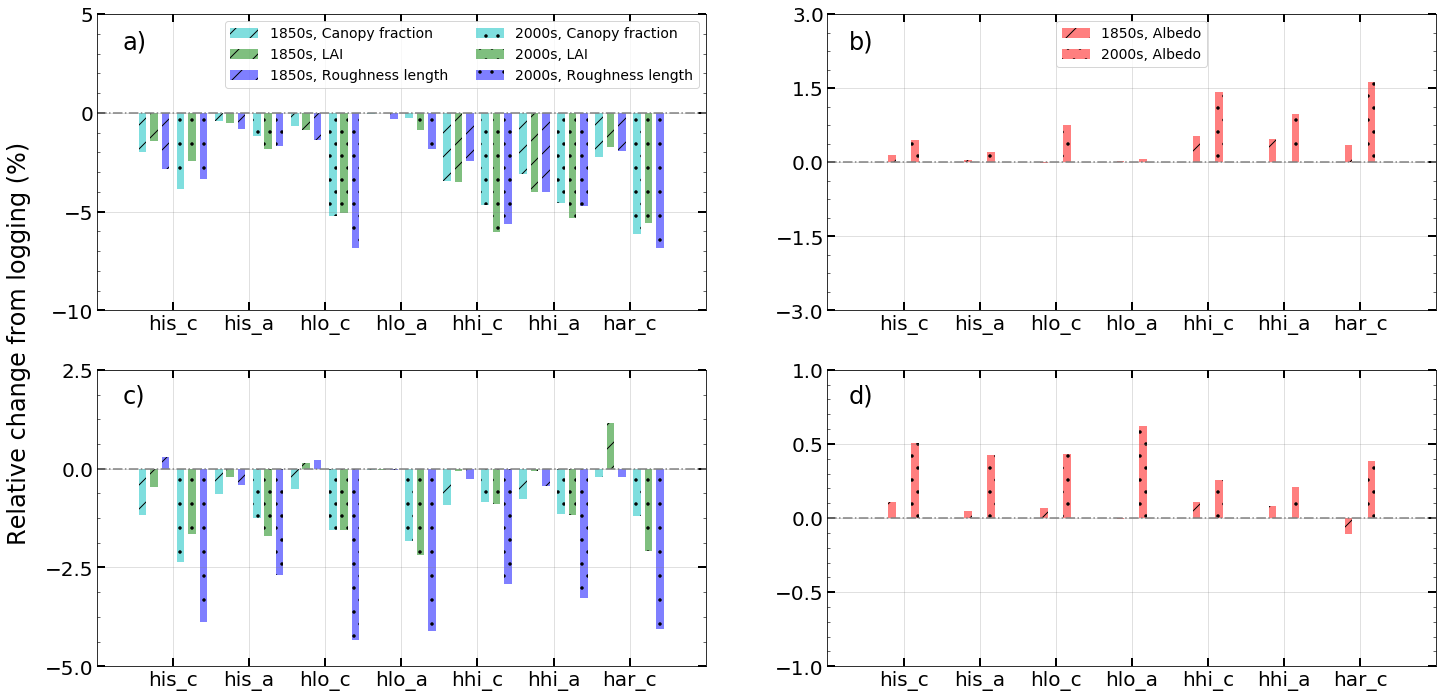

In [36]:
# Subplot for a) Extra-tropical CR and RL, b) Extra-tropics ALB, c) Tropical CR and RL and d) Tropical ALB
fig = plt.figure(figsize=(24,12))

# Shared resources
plt.rcParams.update({'font.size': 18})
patterns = ["/", "."]
tag_list = copy.deepcopy(modname_hrv)

ax1 = fig.add_subplot(221)
xpos11 = [0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
xpos12 = [0.75, 1.75, 2.75, 3.75, 4.75, 5.75, 6.75]
xpos13 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9]
xpos21 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]
xpos22 = [1.25, 2.25, 3.25, 4.25, 5.25, 6.25, 7.25]
xpos23 = [1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4]

senpriplt11 = ax1.bar(xpos11, y11, width=0.1, align='center', color='c', hatch=patterns[0], alpha=0.5)
senpriplt12 = ax1.bar(xpos12, y18, width=0.1, align='center', color='g', hatch=patterns[0], alpha=0.5)
senpriplt13 = ax1.bar(xpos13, y17, width=0.1, align='center', color='b', hatch=patterns[0], alpha=0.5)

senpriplt21 = ax1.bar(xpos21, y21, width=0.1, align='center', color='c', hatch=patterns[1], alpha=0.5)
senpriplt22 = ax1.bar(xpos22, y28, width=0.1, align='center', color='g', hatch=patterns[1], alpha=0.5)
senpriplt23 = ax1.bar(xpos23, y27, width=0.1, align='center', color='b', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
ax1.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-10.0, -5.0, 0.0, 5.0], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-10.0, 5.0))
ax1.legend(['1850s, Canopy fraction', '1850s, LAI', '1850s, Roughness length', 
            '2000s, Canopy fraction', '2000s, LAI', '2000s, Roughness length'], loc='upper right', ncol=2, fontsize=14)
ax1.minorticks_on()
ax1.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax1.tick_params(axis='x',which='minor',bottom='off')
ax1.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax1.tick_params(axis='y',which='minor',direction='in',length=3)
ax1.tick_params(axis="x", which="major", top=True)
ax1.tick_params(axis="y", which="both", right=True)
ax1.plot([0, 9], [0, 0], 'gray', linestyle='-.')
# plt.xlabel('Cases', fontsize=24)
# plt.ylabel('Relative change from logging (%)', fontsize=24)

ax2 = fig.add_subplot(222)
xpos11 = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85]
xpos21 = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15]

senpriplt11 = ax2.bar(xpos11, y12, width=0.1, align='center', color='r', hatch=patterns[0], alpha=0.5)
senpriplt21 = ax2.bar(xpos21, y22, width=0.1, align='center', color='r', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
# ax2.yscale('symlog', linthreshy=0.1, linscale=1.0)
ax2.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-3.0, -1.5, 0.0, 1.5, 3.0], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-3.0, 3.0))
ax2.legend(['1850s, Albedo', 
            '2000s, Albedo'], loc='upper center', fontsize=14)
ax2.minorticks_on()
ax2.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax2.tick_params(axis='x',which='minor',bottom='off')
ax2.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax2.tick_params(axis='y',which='minor',direction='in',length=3)
ax2.tick_params(axis="x", which="major", top=True)
ax2.tick_params(axis="y", which="both", right=True)
ax2.plot([0, 9], [0, 0], 'gray', linestyle='-.')
# plt.xlabel('Cases', fontsize=24)
# plt.ylabel('Relative change from logging (%)', fontsize=24)

ax3 = fig.add_subplot(223)
xpos11 = [0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
xpos12 = [0.75, 1.75, 2.75, 3.75, 4.75, 5.75, 6.75]
xpos13 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9]
xpos21 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]
xpos22 = [1.25, 2.25, 3.25, 4.25, 5.25, 6.25, 7.25]
xpos23 = [1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4]

senpriplt11 = ax3.bar(xpos11, y31, width=0.1, align='center', color='c', hatch=patterns[0], alpha=0.5)
senpriplt12 = ax3.bar(xpos12, y38, width=0.1, align='center', color='g', hatch=patterns[0], alpha=0.5)
senpriplt13 = ax3.bar(xpos13, y37, width=0.1, align='center', color='b', hatch=patterns[0], alpha=0.5)

senpriplt21 = ax3.bar(xpos21, y41, width=0.1, align='center', color='c', hatch=patterns[1], alpha=0.5)
senpriplt22 = ax3.bar(xpos22, y48, width=0.1, align='center', color='g', hatch=patterns[1], alpha=0.5)
senpriplt23 = ax3.bar(xpos23, y47, width=0.1, align='center', color='b', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
ax3.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-5.0, -2.5, 0.0, 2.5], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-5.0, 2.5))
# ax3.legend(['1850s, Canopy fraction', '1850s, Roughness length', 
#             '2000s, Canopy fraction', '2000s, Roughness length'], loc='upper left', ncol=2, fontsize=14)
ax3.minorticks_on()
ax3.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax3.tick_params(axis='x',which='minor',bottom='off')
ax3.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax3.tick_params(axis='y',which='minor',direction='in',length=3)
ax3.tick_params(axis="x", which="major", top=True)
ax3.tick_params(axis="y", which="both", right=True)
ax3.plot([0, 9], [0, 0], 'gray', linestyle='-.')

ax4 = fig.add_subplot(224)
xpos11 = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85]
xpos21 = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15]

senpriplt11 = ax4.bar(xpos11, y32, width=0.1, align='center', color='r', hatch=patterns[0], alpha=0.5)
senpriplt21 = ax4.bar(xpos21, y42, width=0.1, align='center', color='r', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
# ax2.yscale('symlog', linthreshy=0.1, linscale=1.0)
ax4.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-1.0, 1.0))
# ax4.legend(['1850s, Albedo', 
#             '2000s, Albedo'], loc='upper left', fontsize=14)
ax4.minorticks_on()
ax4.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax4.tick_params(axis='x',which='minor',bottom='off')
ax4.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax4.tick_params(axis='y',which='minor',direction='in',length=3)
ax4.tick_params(axis="x", which="major", top=True)
ax4.tick_params(axis="y", which="both", right=True)
ax4.plot([0, 9], [0, 0], 'gray', linestyle='-.')
fig.text(0.14, 0.84, 'a)', fontsize=24)
fig.text(0.56, 0.84, 'b)', fontsize=24)
fig.text(0.14, 0.43, 'c)', fontsize=24)
fig.text(0.56, 0.43, 'd)', fontsize=24)

fig.text(0.08, 0.5, 'Relative change from logging (%)', ha='center', va='center', rotation='vertical', fontsize=24)
plt.savefig('fig5.png')

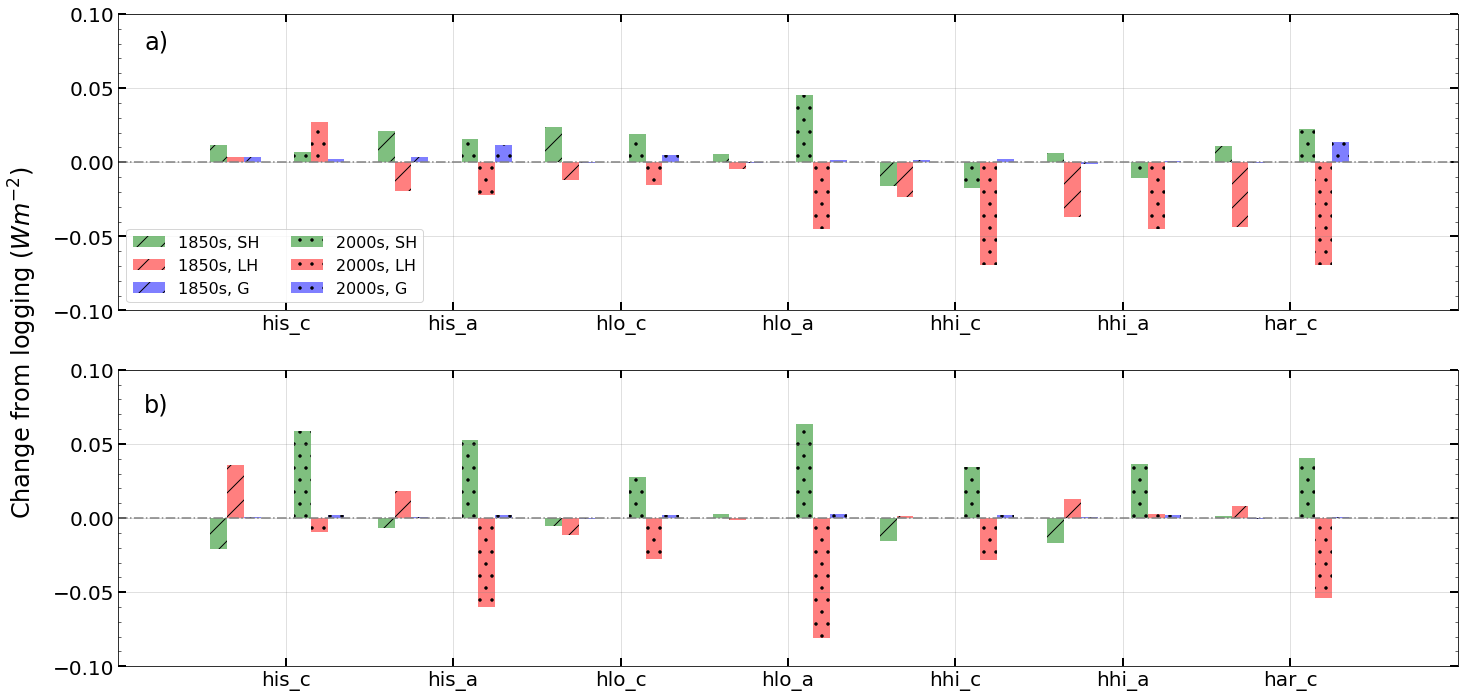

In [31]:
# Bar plot for energy in the default unit
# Subplot for a) Extra-tropical energy budget and b) Tropical energy budget
fig = plt.figure(figsize=(24,12))

# Shared resources
plt.rcParams.update({'font.size': 18})
patterns = ["/", "."]
tag_list = copy.deepcopy(modname_hrv)

ax5 = fig.add_subplot(211)
patterns = ["/", "."]
xpos11 = [0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
xpos12 = [0.7, 1.7, 2.7, 3.7, 4.7, 5.7, 6.7]
xpos13 = [0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 6.8]
xpos14 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9]
xpos21 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]
xpos22 = [1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2]
xpos23 = [1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3]
xpos24 = [1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4]

senpriplt11 = ax5.bar(xpos11, y13, width=0.1, align='center', color='g', hatch=patterns[0], alpha=0.5)
senpriplt12 = ax5.bar(xpos12, y14, width=0.1, align='center', color='r', hatch=patterns[0], alpha=0.5)
senpriplt13 = ax5.bar(xpos13, y15, width=0.1, align='center', color='b', hatch=patterns[0], alpha=0.5)
# senpriplt14 = ax5.bar(xpos14, y16, width=0.1, align='center', color='c', hatch=patterns[0], alpha=0.5)

senpriplt21 = ax5.bar(xpos21, y23, width=0.1, align='center', color='g', hatch=patterns[1], alpha=0.5)
senpriplt22 = ax5.bar(xpos22, y24, width=0.1, align='center', color='r', hatch=patterns[1], alpha=0.5)
senpriplt23 = ax5.bar(xpos23, y25, width=0.1, align='center', color='b', hatch=patterns[1], alpha=0.5)
# senpriplt24 = ax5.bar(xpos24, y26, width=0.1, align='center', color='c', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
ax5.grid(color='gray', which='major', axis='both', alpha=0.3)
# plt.yscale('symlog', linthreshy=0.01, linscale=1.0)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.1], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-0.1, 0.1))
ax5.legend(['1850s, SH', '1850s, LH', '1850s, G',
            '2000s, SH', '2000s, LH', '2000s, G'], loc='lower left', ncol=2, fontsize=16)
ax5.minorticks_on()
ax5.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax5.tick_params(axis='x',which='minor',bottom='off')
ax5.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax5.tick_params(axis='y',which='minor',direction='in',length=3)
ax5.tick_params(axis="x", which="major", top=True)
ax5.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
ax5.plot([0, 9], [0, 0], 'gray', linestyle='-.')
# plt.xlabel('Cases', fontsize=24)
# plt.ylabel('Relative change from logging (%)', fontsize=24)

ax6 = fig.add_subplot(212)
patterns = ["/", "."]
xpos11 = [0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
xpos12 = [0.7, 1.7, 2.7, 3.7, 4.7, 5.7, 6.7]
xpos13 = [0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 6.8]
xpos14 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9]
xpos21 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]
xpos22 = [1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2]
xpos23 = [1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3]
xpos24 = [1.4, 2.4, 3.4, 4.4, 5.4, 6.4, 7.4]

senpriplt11 = ax6.bar(xpos11, y33, width=0.1, align='center', color='g', hatch=patterns[0], alpha=0.5)
senpriplt12 = ax6.bar(xpos12, y34, width=0.1, align='center', color='r', hatch=patterns[0], alpha=0.5)
senpriplt13 = ax6.bar(xpos13, y35, width=0.1, align='center', color='b', hatch=patterns[0], alpha=0.5)
# senpriplt14 = ax6.bar(xpos14, y36, width=0.1, align='center', color='c', hatch=patterns[0], alpha=0.5)

senpriplt21 = ax6.bar(xpos21, y43, width=0.1, align='center', color='g', hatch=patterns[1], alpha=0.5)
senpriplt22 = ax6.bar(xpos22, y44, width=0.1, align='center', color='r', hatch=patterns[1], alpha=0.5)
senpriplt23 = ax6.bar(xpos23, y45, width=0.1, align='center', color='b', hatch=patterns[1], alpha=0.5)
# senpriplt24 = ax6.bar(xpos24, y46, width=0.1, align='center', color='c', hatch=patterns[1], alpha=0.5)

ind = [1,2,3,4,5,6,7]
ax6.grid(color='gray', which='major', axis='both', alpha=0.3)
# plt.yscale('symlog', linthreshy=0.01, linscale=1.0)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.1], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-0.1, 0.1))
# ax6.legend(['1850s, SH', '1850s, LH', '1850s, G', '1850s, Absorbed Rad',
#             '2000s, SH', '2000s, LH', '2000s, G', '2000s, Absorbed Rad'], loc='lower left', ncol=2, fontsize=16)
ax6.minorticks_on()
ax6.tick_params(axis='x',which='major',direction='in',length=8, width=2)
ax6.tick_params(axis='x',which='minor',bottom='off')
ax6.tick_params(axis='y',which='major',direction='in',length=8, width=2)
ax6.tick_params(axis='y',which='minor',direction='in',length=3)
ax6.tick_params(axis="x", which="major", top=True)
ax6.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
ax6.plot([0, 9], [0, 0], 'gray', linestyle='-.')
fig.text(0.14, 0.84, 'a)', fontsize=24)
fig.text(0.14, 0.42, 'b)', fontsize=24)
fig.text(0.07, 0.5, 'Change from logging ($W m^{-2}$)', ha='center', va='center', rotation='vertical', fontsize=24)

plt.savefig('fig6.png')

In [ ]:
# Separate the impact into direct logging and regrowth
# Assume the contribution from logging and regrowth to land surface properties and energy fluxes are addible.



In [ ]:
# Plot to show
if(1):
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, land_4x5_trop[:,:], 60, levels=np.linspace(-0.02, 0.02, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
    fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [-0.02, -0.01, 0.0, 0.01, 0.02] )
    plt.show()



In [ ]:
# Plot to show
if(1):
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, cr_area_logging_2[2][:,:]/(area_4x5*land_4x5_extrop), 60, levels=np.linspace(-0.2, 0.2, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
    fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [-0.1, -0.2, 0.0, 0.1, 0.2] )
    plt.show()

In [ ]:
# Pick a certain point to analyze?
sel_array = alb_logging_2[2][:,:]/(area_4x5*land_4x5_extrop)
np.where(sel_array > 0.005)


In [ ]:
alb_logging_2[2][13,30]/(area_4x5[13,30]*land_4x5_extrop[13,30])

In [ ]:
np.mean(ck[3][64*12:64*12+12,32,55])

In [9]:
np.mean(ref_sr[4][64*12:64*12+12,32,55])

38.752087910970054

In [16]:
alb_site = np.zeros((nyr))
cr_area_site = np.zeros((nyr))
cr_area_top_site = np.zeros((nyr))
for iyr in np.arange(0,nyr):
    cr_area_site[iyr] = np.mean(cr_area_cl[3][iyr*12:iyr*12+12,0,32,55]+cr_area_cl[3][iyr*12:iyr*12+12,1,32,55])
    cr_area_top_site[iyr] = np.mean(cr_area_cl[3][iyr*12:iyr*12+12,0,32,55])
    alb_site[iyr] = np.mean((ref_sr_d[3][iyr*12:iyr*12+12,32,55]+ref_sr_i[3][iyr*12:iyr*12+12,32,55])/tot_sr[3][iyr*12:iyr*12+12,32,55])

Text(0,0.5,'SW reflectance')

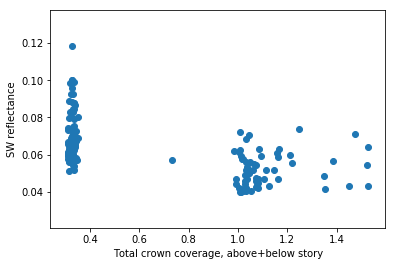

In [17]:
plt.scatter(cr_area_site, alb_site)
plt.xlabel('Total crown coverage, above+below story')
plt.ylabel('SW reflectance')

Text(0,0.5,'SW reflectance')

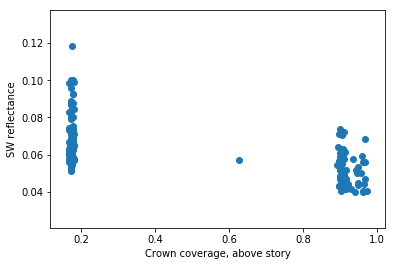

In [18]:
plt.scatter(cr_area_top_site, alb_site)
plt.xlabel('Crown coverage, above story')
plt.ylabel('SW reflectance')

In [ ]:
np.mean(cr_area_cl[4][64*12:64*12+12,0,32,55]+cr_area_cl[4][64*12:64*12+12,1,32,55])

In [ ]:
abs_sr[3][64*12:64*12+12,32,55]

In [ ]:
abs_sr[4][64*12:64*12+12,32,55]

In [11]:
ref_sr[3][165*12:165*12+12,13,30]

masked_array(data=[53.59532928466797, 43.51457595825195,
                   38.51997756958008, 27.002817153930664,
                   22.390594482421875, 15.97967529296875,
                   17.81386375427246, 24.301977157592773,
                   32.5424919128418, 41.84141540527344, 51.31378173828125,
                   53.197879791259766],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+36,
            dtype=float32)

In [ ]:
ref_sr[4][160*12:160*12+12,13,30]

In [ ]:
cr_area_cl[3][160*12:160*12+12,0,13,30]

In [ ]:
cr_area_cl[4][160*12:160*12+12,0,13,30]

In [ ]:
# Direct vs. regrowth
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# All BGP responses
cr_area = []
cr_area_mean = []
alb = []
alb_mean = []
sh = []
sh_mean = []
lh = []
lh_mean = []
gh = []
gh_mean = []
abs_rad = []
abs_rad_mean = []
rlength = []
rlength_mean= []

totlen = nyr*12
for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    alb_ts = np.zeros((nyr, 46, 72))
    sh_ts = np.zeros((nyr, 46, 72))
    lh_ts = np.zeros((nyr, 46, 72))
    gh_ts = np.zeros((nyr, 46, 72))
    abs_ts = np.zeros((nyr, 46, 72))
    rl_ts = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    alb_masked_ts = np.ma.masked_array(alb_ts)
    sh_masked_ts = np.ma.masked_array(sh_ts)
    lh_masked_ts = np.ma.masked_array(lh_ts)
    gh_masked_ts = np.ma.masked_array(gh_ts)
    abs_masked_ts = np.ma.masked_array(abs_ts)
    rl_masked_ts = np.ma.masked_array(rl_ts)
    for iyr in np.arange(0,totlen):
        # canopy coverage
        cr_area_masked_ts[iyr,:,:] = np.nanmean(cr_area_cl[i][12*iyr:12*iyr+12,0,:,:], 0)
        alb_masked_ts[iyr,:,:] = np.nanmean(ref_sr[i][(iyr*12):(iyr*12+12),:,:], 0)/np.nanmean(tot_sr[i][(iyr*12):(iyr*12+12),:,:], 0)
        sh_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+12,:,:], 0)
        lh_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+12,:,:], 0)
        gh_masked_ts[iyr,:,:] = np.nanmean(tot_gh[i][12*iyr:12*iyr+12,:,:], 0)
        abs_masked_ts[iyr,:,:] = np.nanmean(abs_sr[i][12*iyr:12*iyr+12,:,:], 0)
        rl_masked_ts[iyr,:,:] = copy.deepcopy(rl[i][iyr,:,:])
    if(apply_mask):
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        sh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        gh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        abs_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        rl_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    cr_area_masked_ts[cr_area_masked_ts>1e10] = np.nan
    cr_area.append(cr_area_masked_ts)
    cr_area_mean.append(np.mean(np.mean(cr_area_masked_ts, 1), 1))
    alb_masked_ts[alb_masked_ts>10.0] = np.nan
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))
    sh_masked_ts[sh_masked_ts>1e4] = np.nan
    sh.append(sh_masked_ts)
    sh_mean.append(np.mean(np.mean(sh_masked_ts, 1), 1))
    lh_masked_ts[lh_masked_ts>1e4] = np.nan
    lh.append(lh_masked_ts)
    lh_mean.append(np.mean(np.mean(lh_masked_ts, 1), 1))
    gh_masked_ts[gh_masked_ts>1e4] = np.nan
    gh.append(gh_masked_ts)
    gh_mean.append(np.mean(np.mean(gh_masked_ts, 1), 1))
    abs_masked_ts[abs_masked_ts>1e4] = np.nan
    abs_rad.append(abs_masked_ts)
    abs_rad_mean.append(np.mean(np.mean(abs_masked_ts, 1), 1))
    rl_masked_ts[rl_masked_ts>100.0] = np.nan
    rlength.append(rl_masked_ts)
    rlength_mean.append(np.mean(np.mean(rl_masked_ts, 1), 1))
    
sel_yr = np.arange(0,10)
# First output: casesxlatxlon logging impact (difference between with and without logging cases)
# Second output: averaged impact per case over masked region
[cr_area_logging_d, dy1] = obtain_dir_logging_impact_ts(modname, cr_area, 0, 165)
[alb_logging_d, dy2] = obtain_dir_logging_impact_ts(modname, alb, 0, 165)
[sh_logging_d, dy3] = obtain_dir_logging_impact_ts(modname, sh, 0, 165)
[lh_logging_d, dy4] = obtain_dir_logging_impact_ts(modname, lh, 0, 165)
[gh_logging_d, dy5] = obtain_dir_logging_impact_ts(modname, gh, 0, 165)
[abs_rad_logging_d, dy6] = obtain_dir_logging_impact_ts(modname, abs_rad, 0, 165)
[rlength_logging_d, dy7] = obtain_dir_logging_impact_ts(modname, rlength, 0, 165)

# patterns = ["/", "."]
# xpos11 = [0.7, 1.7, 2.7, 3.7, 4.7, 5.7, 6.7]
# xpos12 = [0.8, 1.8, 2.8, 3.8, 4.8, 5.8, 6.8]
# xpos13 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9]
# xpos21 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1]
# xpos22 = [1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2]
# xpos23 = [1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3]

# plt.figure(figsize=(16,10))
# senpriplt11 = plt.bar(xpos11, y11, width=0.1, align='center', color='g', hatch=patterns[0], alpha=0.5)
# senpriplt12 = plt.bar(xpos12, y12, width=0.1, align='center', color='r', hatch=patterns[0], alpha=0.5)
# senpriplt13 = plt.bar(xpos13, y17, width=0.1, align='center', color='b', hatch=patterns[0], alpha=0.5)

# senpriplt21 = plt.bar(xpos21, y21, width=0.1, align='center', color='g', hatch=patterns[1], alpha=0.5)
# senpriplt22 = plt.bar(xpos22, y22, width=0.1, align='center', color='r', hatch=patterns[1], alpha=0.5)
# senpriplt23 = plt.bar(xpos23, y27, width=0.1, align='center', color='b', hatch=patterns[1], alpha=0.5)

# ind = [1,2,3,4,5,6,7]
# plt.grid(color='gray', which='major', axis='both', alpha=0.3)
# plt.yscale('symlog', linthreshy=0.1, linscale=1.0)
# # plt.yscale('asinh', linear_width=0.2, base=2)
# plt.xticks(ind, tag_list, fontsize=20)
# plt.yticks([-10, -1, -1e-1, 0.0, 1e-1, 1, 10], fontsize=20)
# plt.xlim((0, 8))
# plt.ylim((-15.0, 15.0))
# plt.legend(['1850s, Canopy fraction', '1850s, Albedo', '1850s, Roughness length', 
#             '2000s, Canopy fraction', '2000s, Albedo', '2000s, Roughness length'], loc='upper right', fontsize=16)
# plt.minorticks_on()
# plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
# plt.tick_params(axis='x',which='minor',bottom='off')
# plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
# plt.tick_params(axis='y',which='minor',direction='in',length=3)
# plt.tick_params(axis="x", which="major", top=True)
# plt.tick_params(axis="y", which="both", right=True)
# #plt.plot(mpos_top, bline_top,'k')
# #plt.plot(mpos_sub, bline_sub,'k')
# plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
# plt.xlabel('Cases', fontsize=24)
# plt.ylabel('Relative change from logging (%)', fontsize=24)


In [ ]:
np.shape(dy1)

In [ ]:
dy1[0]

In [ ]:
# Violin chart to show how different the mean canopy coverage for different cases
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# Pick the two periods (1850s and 2000s) 
p1_beg = 0
p1_end = 10
p2_beg = nyr-10
p2_end = nyr-1

# flatten to 2-D array                
cr_area_diff_p1 = np.empty((7,3312))
cr_area_diff_p2 = np.empty((7,3312))
cr_area_diff_p1[:] = np.nan
cr_area_diff_p2[:] = np.nan

for i in np.arange(0, len(plot_case_list)):
    cr_area_diff_p1[i, :] = np.nanmean(cr_area_logging[i][p1_beg:p1_end,:,:], 0).flatten()
    cr_area_diff_p2[i, :] = np.nanmean(cr_area_logging[i][p2_beg:p2_end,:,:], 0).flatten()

# Box plot by group
# Transfer into a list for different cases
bar_data = []
for j in np.arange(0, len(plot_case_list)):
    sample_t = copy.deepcopy(cr_area_diff_p2[j,:])
    # remove nans
    sample_t = sample_t[~np.isnan(sample_t)]
    # remove zeros
    sample_t = sample_t[sample_t != 0]
    bar_data.append(sample_t)

fig = plt.figure(figsize =(15, 10))
plt.rcParams.update({'font.size': 16})

# Creating plot
# plt.boxplot(bar_data)
plt.violinplot(bar_data[0:7], showmeans=True, showmedians=False, showextrema=False)
plt.xlabel('Cases', fontsize=20)
plt.ylabel('Logging induced canopy cover change (fraction)', fontsize=20)
# plt.xlim(0, 6)
plt.ylim(-0.01, 0.01)

# show plot
plt.show()


In [ ]:
np.shape(cr_area_diff_p1)

In [ ]:
tt = cr_area_diff_p1[6]
tt[~np.isnan(tt)]

In [ ]:
# Violin chart to show how different the mean canopy coverage across different biomes
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# Pick the two periods (1850s and 2000s) 
p1_beg = 0
p1_end = 10
p2_beg = nyr-10
p2_end = nyr-1

cr_area_pf_yr = []
cr_area_pf_mean = []

# Obtain the time series
for i in np.arange(0,case_len):
    cr_area_pf_ts = np.zeros((nyr, 12, 46, 72))
    cr_area_pf_masked_ts = np.ma.masked_array(cr_area_pf_ts)
    for iyr in np.arange(0,nyr):
        cr_area_pf_masked_ts[iyr,:,:,:] = cr_area_pf[i][12*iyr+1,:,:,:]
    if(apply_mask):
        cr_area_pf_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    cr_area_pf_yr.append(cr_area_pf_masked_ts)

# Calculate diff against no logging case
cr_area_pf_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                cr_area_pf_diff.append(cr_area_pf_yr[i][:,:,:,:] - cr_area_pf_yr[i+1][:,:,:,:])
            else:
                cr_area_pf_diff.append(cr_area_pf_yr[i][:,:,:,:] - cr_area_pf_yr[1][:,:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                cr_area_pf_diff.append(cr_area_pf_yr[i][:,:,:,:] - cr_area_pf_yr[i-1][:,:,:,:])

# flatten to 2-D array                
cr_area_diff_p1 = np.empty((7,9,3312))
cr_area_diff_p2 = np.empty((7,9,3312))
cr_area_diff_p1[:] = np.nan
cr_area_diff_p2[:] = np.nan

for i in np.arange(0, len(plot_case_list)):
    for j in np.arange(0, 9):
        cr_area_diff_p1[i, j, :] = np.nanmean(cr_area_pf_diff[i][p1_beg:p1_end,j,:,:], 0).flatten()
        cr_area_diff_p2[i, j, :] = np.nanmean(cr_area_pf_diff[i][p2_beg:p2_end,j,:,:], 0).flatten()

# Box plot by group
# Transfer into a list for different cases
bar_data = []
for j in np.arange(0,9):
    sample_t = copy.deepcopy(cr_area_diff_p1[6,j,:])
    # remove nans
    sample_t = sample_t[~np.isnan(sample_t)]
    # remove zeros
    sample_t = sample_t[sample_t != 0]
    bar_data.append(sample_t)

fig = plt.figure(figsize =(10, 7))
plt.rcParams.update({'font.size': 16})

# Creating plot
# plt.boxplot(bar_data)
plt.violinplot(bar_data[0:6], showmeans=True, showmedians=False, showextrema=False)
plt.xlabel('PFTs', fontsize=20)
plt.ylabel('Logging induced canopy cover change (fraction)', fontsize=20)
# plt.xlim(0, 6)
plt.ylim(-0.3, 0.3)
    
# show plot
plt.show()

# xax = np.arange(-1,7)
# yax = np.arange(-1,7)
# plt.plot(xax, yax, 'r--')
# plt.xlim(0, 6)
# plt.ylim(0, 6)

In [ ]:
np.shape(bar_data[0:6])

### Calculate the surface roughness length following FATES and ELM big-leaf approach

In [19]:
## Constants for the calculation
# Ratio of momentum roughness length to canopy top height
# The roughness length is calculated by combining the contrubution from above-story forest and understory soil.
# Notably it is a simplfied approach that certain understory grass may have a bit larger roughness length comparing
# to soil, however for simplcity we ignore their contribution
# It is strange that calculation involving "fates_area_frac" will get corrupted results 
z0mr = 0.055
rl_soil = 0.01
idt = np.ones((46, 72))
# crown area-weighted mean height of canopy plants
# Forest + (grass & crop) part
rl = []
for i in np.arange(0,case_len):
    rl_per_case = np.zeros((nyr, 46, 72))
    # Get the value from each Febuary
    for iyr in np.arange(0, nyr):
        rl_per_case[iyr,:,:] = (z0mr * hite[i][12*iyr,:,:] * cr_area_cl[i][12*iyr,0,:,:])# * fates_area_frac[i][12*iyr,:,:] + (1.0 - cr_area_cl[i][12*iyr,0,:,:]) * rl_soil) # + (1 - fates_area_frac[i][12*iyr,:,:]) * z0mr * rl_soil
    rl.append(rl_per_case)

In [ ]:
# Validate the calculated roughness length
if(verbose):
    sel_yr = nyr
    rl_sel = []
    for i in np.arange(0, len(modname)):
        rl_sel.append(rl[i][sel_yr-1,:,:])
    set_levels = np.linspace(0, 2.0, 101)
    set_ticks = [0, 0.5, 1.0, 1.5, 2.0]
    set_unit_tag = 'Unit: m'
    save_path = './roughness_length_2015.png'
    # Plot albedo for all cases
    plot_all_cases(modname, sel_yr, rl_sel, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)

In [ ]:
# Time series of the change in surface roughness length
apply_mask = True
logging_plot = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
rl_for = []
rl_mean = []
rl_for_logging = []
rl_for_logging_global = []

for i in np.arange(0,case_len):
    rl_ts = np.zeros((nyr, 46, 72))
    rl_masked_ts = np.ma.masked_array(rl_ts)
    for iyr in np.arange(0,nyr):
        rl_masked_ts[iyr,:,:] = rl[i][iyr,:,:]
    if(apply_mask):
        rl_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    rl_for.append(rl_masked_ts)
    rl_mean.append(np.nanmean(np.nanmean(rl_masked_ts, 1), 1))

for i in np.arange(0,case_len):
    if(modname[i][4:5] == 'c'):
        if(modname[i] != 'har_c'):
            rl_for_logging.append(rl_for[i][:,:,:] - rl_for[i+1][:,:,:])
        else:
            rl_for_logging.append(rl_for[i][:,:,:] - rl_for[1][:,:,:])
    else:
        if(modname[i][4:5] == 'a'):
            rl_for_logging.append(rl_for[i][:,:,:] - rl_for[i-1][:,:,:])
            
for i in np.arange(0, len(plot_case_list)):
    rl_for_logging_global.append(np.nanmean(np.nanmean(rl_for_logging[i], 1), 1))
    
if(logging_plot):
    # Plots
    color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-4)
    plt.figure(figsize=(10,8), dpi=300)
    for imod in np.arange(0, len(plot_case_list)):
        plt.plot(yr_axis, moving_average(rl_for_logging_global[imod][:]), color_list[imod])
    plt.legend(plot_case_list)
    plt.title('Change of roughness length (m)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year')
    plt.ylabel('Canopy coverage')
    plt.savefig('./canopy_coverage_ts.png')
else:
    # Plots
    color_list = ['r-', 'r*', 'r--', 'g-', 'g*', 'g--', 'b-', 'b*', 'b--', 'gray']
    yr_axis = yr_beg + np.arange(5,nyr-4)
    plt.figure(figsize=(10,8))
    for imod in np.arange(0, case_len):
        plt.plot(yr_axis, moving_average(rl_for_mean[imod][:]), color_list[imod])
    plt.legend(modname)
    plt.title('Canopy coverage (0 - 2)')
    # plt.ylim([0.53, 0.77])
    plt.xlabel('Year since 1850')
    plt.ylabel('Canopy coverage')

In [ ]:
debug = True
if(debug):
    # Harvested C from har-c case (or other specific case if change the modname)
    lonnc_new = copy.deepcopy(lonnc[0,:])
    latnc_new = copy.deepcopy(latnc[:,0])
    sel_yr = 3
    for i in np.arange(0,len(modname)):
        if(modname[i] == 'hlo_a'):
            hrvc_new = copy.deepcopy(np.nanmean(cr_area[i][10:20,:,:], 0))
#             hrvc_new[hrvc_new<=0] = np.float('nan')
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc_new, latnc_new, hrvc_new[:,:], 60, levels=np.linspace(-0.2, 0.2, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'FATES - Global harvested C', fontsize=16)
    fig.text(0.25, 0.22, 'Biomass C (kgC m-2)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [-0.2, -0.1, 0, 0.1, 0.2] )
    plt.show()
    # plt.savefig('HRV_C_FATES.png')

In [ ]:
# Initial plot for animation 
sel_yr = nyr
rl_sel = []
for i in np.arange(0, len(modname_hrv)):
    #rl_sel.append(cr_sel[i][16,:,:])
    rl_sel.append(np.nanmean(cr_area_logging[i][130:131,:,:], 0))
set_levels = np.linspace(-0.2, 0.2, 101)
set_ticks = [-0.2, -0.1, 0.0, 0.1, 0.2]
set_unit_tag = 'Unit: m'
save_path = './harvested_c_2015.png'
# Plot change by logging activity for all cases
[fig, axs] = plot_logging_cases(modname_hrv, sel_yr, rl_sel, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)

In [ ]:
# The process producing animation may take up to 20 mins or even longer
make_movie = True
if(make_movie):
    ndecades = 17
    cr_sel = []
    for i in np.arange(0, len(modname_hrv)):
        cr_area = np.zeros((ndecades, 46, 72))
        # Perform average for every 10 years
        for j in np.arange(0, ndecades):
            if (j<ndecades-1):
                cr_area[j,:,:] = np.nanmean(cr_area_logging[i][10*j:10*j+10,:,:], 0)
            else:
                cr_area[j,:,:] = np.nanmean(cr_area_logging[i][10*j:np.shape(cr_area_logging)[1],:,:], 0)           
        cr_sel.append(cr_area)
    arrays = cr_sel

    # plot function for animation, gets called for each frame
    def animate(yr):
        # Subplot of all cases 
        for i in np.arange(0, len(modname_hrv)):
            # Contour plot
            cs=axs[i].contourf(lonnc, latnc, arrays[i][yr,:,:], levels=np.linspace(-0.2, 0.2, 101), \
                           transform=ccrs.PlateCarree(), cmap=plt.cm.jet, extend='both')
        year_id = 1850+yr*10
        fig.suptitle(str(year_id)+'s', fontsize=16)
        return [axs]

    # Produce animation
    anim = animation.FuncAnimation(fig, animate, frames=17, interval=1000)
    HTML(anim.to_jshtml())
    anim.save('roughness_length.html')
    # Need to install imagemagick before using the GIT writer. Or maybe to check after upgrading the anaconda
#     cwriter = animation.FFMpegWriter(fps=1)

In [ ]:
HTML(anim.to_jshtml())

### Calculate regrowth vs. logging 

In [ ]:
# Regrowth vs. logging loss: first method
# (1) Calculate this by checking the canopy coverage comparing to the previous year. 
# If the canopy area increase, we assume current grid is under regrowth
# Otherwise, this grid is domianted by logging impact
# (2) Check the change of logging area as a comparison.
cr_area_diff = []
for i in np.arange(0,case_len):
    cr_area_diff.append(cr_area[i][1:nyr,:,:] - cr_area[i][0:(nyr-1),:,:])
sel_yr = nyr - 1
dcr_ts = []
dcr_1850 = []
dcr_2015 = []
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c'):
        if(modname[i] != 'har_c'):
            dcr_ts.append(cr_area_diff[i][:,:,:] - cr_area_diff[i+1][:,:,:])
            dcr_1850.append(cr_area_diff[i][0,:,:] - cr_area_diff[i+1][0,:,:])
            dcr_2015.append(cr_area_diff[i][sel_yr-1,:,:] - cr_area_diff[i+1][sel_yr-1,:,:])
        else:
            dcr_ts.append(cr_area_diff[i][:,:,:] - cr_area_diff[1][:,:,:])
            dcr_1850.append(cr_area_diff[i][0,:,:] - cr_area_diff[1][0,:,:])
            dcr_2015.append(cr_area_diff[i][sel_yr-1,:,:] - cr_area_diff[1][sel_yr-1,:,:])
    else:
        if(modname[i][4:5] == 'a'):
            dcr_ts.append(cr_area_diff[i][:,:,:] - cr_area_diff[i-1][:,:,:])
            dcr_1850.append(cr_area_diff[i][0,:,:] - cr_area_diff[i-1][0,:,:])
            dcr_2015.append(cr_area_diff[i][sel_yr-1,:,:] - cr_area_diff[i-1][sel_yr-1,:,:])
# Other options for plot
set_levels = np.linspace(-0.5, 0.5, 101)
set_ticks = [-0.5, -0.25, 0, 0.25, 0.5]
set_unit_tag = 'Unit: 0 - 2'
save_path = './diff_canopy_coverage_2015.png'
# Plot albedo for all cases  
plot_logging_cases(modname_hrv, nyr, dcr_2015, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)

# alb = []
# alb_mean = []

# for i in np.arange(0,case_len):
#     alb_ts = np.zeros((nyr, 46, 72))
# #     alb_masked_ts = np.ma.masked_array(alb_ts, mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)].mask)
#     alb_masked_ts = np.ma.masked_array(alb_ts)
#     for iyr in np.arange(0,nyr):
#         alb_masked_ts[iyr,:,:] = np.mean(ref_sr[i][(iyr*12):(iyr*12+12),:,:], 0)/np.mean(tot_sr[i][(iyr*12):(iyr*12+12),:,:], 0)
#     if(apply_mask):
#         alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]    
#     alb.append(alb_masked_ts)

In [ ]:
if(verbose):
    # Validate if the mask is working properly
    # make plot
    fig = plt.figure(figsize=(10,10), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs = plt.contourf(lonnc, latnc, cr_area_diff[9].mask[164,:,:], 60, levels=np.linspace(0.0, 1.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
    fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
    cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0] )
    plt.show()

In [ ]:
# Regrowth vs. logging loss: second method
# (1) Check this by checking the biomass comparing to the previous year. 
# If the biomass increase, we assume current grid is under regrowth
# Otherwise, this grid is under logging impact
# (2) Check the change of logging area as a comparison.
bm_diff = []
cur = np.zeros((nyr, 46, 72))
for i in np.arange(0,case_len):
    for j in np.arange(0,nyr):
        cur[j,:,:] = np.nanmean(vegc[i][12*j:12*j+12,:,:], 0)
    bm_diff.append(cur[1:nyr,:,:] - cur[0:(nyr-1),:,:])

sel_yr = nyr - 1
dbm_ts = []
dbm_1850 = []
dbm_2015 = []
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c'):
        if(modname[i] != 'har_c'):
            dbm_ts.append(bm_diff[i][:,:,:] - bm_diff[i+1][:,:,:])
            dbm_1850.append(bm_diff[i][0,:,:] - bm_diff[i+1][0,:,:])
            dbm_2015.append(bm_diff[i][sel_yr-1,:,:] - bm_diff[i+1][sel_yr-1,:,:])
        else:
            dbm_ts.append(bm_diff[i][:,:,:] - bm_diff[1][:,:,:])
            dbm_1850.append(bm_diff[i][0,:,:] - bm_diff[1][0,:,:])
            dbm_2015.append(bm_diff[i][sel_yr-1,:,:] - bm_diff[1][sel_yr-1,:,:])
    else:
        if(modname[i][4:5] == 'a'):
            dbm_ts.append(bm_diff[i][:,:,:] - bm_diff[i-1][:,:,:])
            dbm_1850.append(bm_diff[i][0,:,:] - bm_diff[i-1][0,:,:])
            dbm_2015.append(bm_diff[i][sel_yr-1,:,:] - bm_diff[i-1][sel_yr-1,:,:])

# Other options for plot
set_levels = np.linspace(-0.5, 0.5, 101)
set_ticks = [-0.5, -0.25, 0, 0.25, 0.5]
set_unit_tag = 'Unit: 0 - 2'
save_path = './diff_biomass_2015.png'
# Plot albedo for all cases
plot_logging_cases(modname_hrv, nyr, dbm_2015, set_levels, set_ticks, set_unit_tag, save_path, savefig = True)

### Albedo

In [ ]:
# Select year and specify variables for plot
sel_yr = nyr
alb = []
for i in np.arange(0,len(modname)):
    alb.append(copy.deepcopy(np.mean(ref_sr[i][(nyr*12-12):(nyr*12),:,:], 0)/np.mean(tot_sr[i][(nyr*12-12):(nyr*12),:,:], 0)))
# Other options for plot
set_levels = np.linspace(0, 1.0, 31)
set_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
set_unit_tag = 'Unit: 0 - 1'
save_path = './albedo_2015.png'
# Plot albedo for all cases
plot_all_cases(modname, sel_yr, alb, set_levels, set_ticks, set_unit_tag, save_path, savefig = False)

In [ ]:
# Albedo of the last year
apply_mask = True
sel_yr = nyr-50
alb = []
alb_diff = []

if(apply_mask):
    for i in np.arange(0,case_len):
        alb_ts = np.zeros((nyr, 46, 72))
        alb_masked_ts = np.ma.masked_array(alb_ts)
        for iyr in np.arange(0,nyr):
            # Note: The calculation will overwrite the mask and even change the assigned mask source, thus all calculations
            # changing the value shall be finished before assigning the mask.
            alb_masked_ts[iyr,:,:] = np.mean(ref_sr[i][(iyr*12):(iyr*12+12),:,:], 0)/np.mean(tot_sr[i][(iyr*12):(iyr*12+12),:,:], 0)
        alb_masked_ts.mask = mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr),:,:]
        alb.append(alb_masked_ts[sel_yr-1, :, :])      
else:
    for i in np.arange(0,len(modname)):
        alb.append(copy.deepcopy(np.mean(ref_sr[i][(sel_yr*12-12):(sel_yr*12),:,:], 0)/np.mean(tot_sr[i][(sel_yr*12-12):(sel_yr*12),:,:], 0)))
    
# Another loop to calculate the diff between cases
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb[i][:,:] - alb[i+1][:,:])
            else:
                alb_diff.append(alb[i][:,:] - alb[1][:,:])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb[i][:,:] - alb[i-1][:,:])

# Other options for plot
set_levels = np.linspace(-0.01, 0.01, 51)
set_ticks = [-0.01, -0.0075, -0.005, -0.0025, 0.0, 0.0025, 0.005, 0.0075, 0.01]
set_unit_tag = 'Unit: %'
save_path = './logging_impact_albedo_2015.png'    
# Plot albedo change by logging activity for all cases
plot_logging_cases(modname_hrv, sel_yr, alb_diff, set_levels, set_ticks, set_unit_tag, save_path, savefig = True)

In [ ]:
# Validate if the mask is working properly
# make plot
fig = plt.figure(figsize=(10,10), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(lonnc, latnc, mask_list[3][160,:,:], 60, levels=np.linspace(0.0, 1.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, 'Check harvest rate mask', fontsize=16)
fig.text(0.25, 0.22, 'Harvest rate prim (kgC yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks = [0, 2e9, 4e9, 6e9, 8e9, 1e10] )
plt.show()

In [ ]:
## Time series
# 1. Shall only check regions after logging for each year
# Logging -> Reduce the canopy coverage -> Increase Albedo -> Regrowth -> Recovered
# However, the recovery takes years, thus the continuous logging cannot be figured out simply by checking the change of seasonality.
# 2. Regions without logging can be used as a background check. I see the difference in the antarctic, thus confused me a lot. 
# But it will take much longer to figure out this issue thus we ignore it for now.

start = time.time()

# Shall put this calculation into numba function
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
alb = []
alb_mean = []

for i in np.arange(0,case_len):
    alb_ts = np.zeros((nyr, 46, 72))
    alb_masked_ts = np.ma.masked_array(alb_ts)
#     alb_masked_ts = np.ma.masked_array(alb_ts)
    for iyr in np.arange(0,nyr):
#         alb_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+12,:,:], 0)
#         alb_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+12,:,:], 0)
#         alb_masked_ts[iyr,:,:] = cr_area[i][iyr,:,:]
        alb_masked_ts[iyr,:,:] = np.mean(ref_sr[i][(iyr*12):(iyr*12+12),:,:], 0)/np.mean(tot_sr[i][(iyr*12):(iyr*12+12),:,:], 0)
    if(apply_mask):
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))

# If calculate the diff between the consecutive years
yr_diff = []
for i in np.arange(0,case_len):
    yr_diff.append(alb[i][1:nyr,:,:] - alb[i][0:(nyr-1),:,:])

sel_yr = nyr - 1
dts = []
for i in np.arange(0,len(modname)):
    if(modname[i][4:5] == 'c'):
        if(modname[i] != 'har_c'):
            dts.append(yr_diff[i][:,:,:] - yr_diff[i+1][:,:,:])
        else:
            dts.append(yr_diff[i][:,:,:] - yr_diff[1][:,:,:])
    else:
        if(modname[i][4:5] == 'a'):
            dts.append(yr_diff[i][:,:,:] - yr_diff[i-1][:,:,:])
            
# Model cases
alb_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb[i] - alb[i+1])
            else:
                alb_diff.append(alb[i] - alb[1])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb[i] - alb[i-1])

for imod in np.arange(0, len(plot_case_list)):
    size_ts = np.shape(alb_diff[imod][1:166,:,:])
    alb_diff[imod][1:166,:,:] = apply_mask_ts(alb_diff[imod][1:166,:,:], dcr_ts[imod], size_ts, 1, 0.05)

for imod in np.arange(0, len(plot_case_list)):
    size_ts = np.shape(dts[imod])
    dts[imod] = apply_mask_ts(dts[imod], dcr_ts[imod], size_ts, 1, 0.05)

end = time.time()
print(end - start)

# # Plots
# color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
# yr_axis = yr_beg + np.arange(75,nyr-5)
# fig = plt.figure(figsize=(8,8), dpi=300)
# for imod in np.arange(0, len(plot_case_list)):
#     plt.plot(yr_axis, moving_average(np.nanmean(np.nanmean(alb_diff[imod][70:nyr, :, :], 1), 1)), color_list[imod])

# plt.legend(plot_case_list)
# #plt.title('Change of albedo')
# # plt.ylim([-0.002, 0.002])
# plt.xlabel('Year since 1850')
# plt.ylabel('Albedo Change')

In [ ]:
# Plots
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
yr_axis = yr_beg + np.arange(75,nyr-5)
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(1,1,1)
for imod in np.arange(0, len(plot_case_list)):
    plt.plot(yr_axis, moving_average(np.nanmean(np.nanmean(alb_diff[imod][70:nyr-1, :, :], 1), 1)), color_list[imod])

plt.legend(plot_case_list)
#plt.title('Change of albedo')
# plt.ylim([-0.002, 0.002])
vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.title('Global change from logging dominant grids (Dimensionless)')
plt.xlabel('Year')
plt.ylabel('Change of Albedo')
plt.savefig('logging_dominant_alb.png')

In [ ]:
# Plots
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
yr_axis = yr_beg + np.arange(75,nyr-5)
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(1,1,1)
for imod in np.arange(0, len(plot_case_list)):
    plt.plot(yr_axis, moving_average(np.nanmean(np.nanmean(alb_diff[imod][70:nyr-1, :, :], 1), 1)), color_list[imod])

plt.legend(plot_case_list)
#plt.title('Change of albedo')
# plt.ylim([-0.002, 0.002])
vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.title('Global latent heat change from logging dominant grids ($W s^{-2}$)')
plt.xlabel('Year')
plt.ylabel('Change of LH')
plt.savefig('logging_dominant_sh.png')

In [ ]:
# Barchart for the selected year
xpos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
sel_yr = nyr
apply_mask = False
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
alb = []
alb_mean = []

for i in np.arange(0,case_len):
    alb_ts = np.zeros((nyr, 46, 72))
#     alb_masked_ts = np.ma.masked_array(alb_ts, mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)].mask)
    alb_masked_ts = np.ma.masked_array(alb_ts)
    for iyr in np.arange(0,nyr):
        alb_masked_ts[iyr,:,:] = np.mean(ref_sr[i][(iyr*12):(iyr*12+12),:,:], 0)/np.mean(tot_sr[i][(iyr*12):(iyr*12+12),:,:], 0)
    if(apply_mask):
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]    
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))

# Model cases
alb_diff = []
alb_mean_deno = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb_mean[i][sel_yr-1] - alb_mean[i+1][sel_yr-1])
                alb_mean_deno.append(alb_mean[i][sel_yr-1])
            else:
                alb_diff.append(alb_mean[i][sel_yr-1] - alb_mean[1][sel_yr-1])
                alb_mean_deno.append(alb_mean[i][sel_yr-1])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb_mean[i][sel_yr-1] - alb_mean[i-1][sel_yr-1])
                alb_mean_deno.append(alb_mean[i][sel_yr-1])

plt.figure(figsize=(16,10))
senpriplt = plt.bar(xpos, np.array(alb_diff)/np.array(alb_mean_deno), width=0.2, align='center', color='r')
ind = [1,2,3,4,5,6,7]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-0.005, -0.0025, 0.0, 0.0025, 0.005], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-0.005, 0.005))
plt.legend(['Primary', 'Secondary Mature', 'Secondary Young'], loc='upper center', fontsize=24)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
plt.xlabel('Cases', fontsize=24)
plt.ylabel('Relative change of albedo (2015, %)', fontsize=24)
#plt.annotate('(a)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30)

#plt.show()

### SH and LH

In [ ]:
## Time series
# Shall only check regions after logging for each year
# Logging -> Increased exposure of surface -> Reduced transpiration -> partition of surface energy from LH towards SH -> Regrowth -> Recovered
# However, the recovery takes years, thus the continuous logging cannot be figured out simply by checking the change of seasonality.

plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
apply_mask = True
sh = []
lh = []
sh_mean = []
lh_mean = []
sh_ts = np.zeros((nyr, 46, 72))
lh_ts = np.zeros((nyr, 46, 72))
sh_masked_ts = np.ma.masked_array(sh_ts, mask=luh2_pri_hv[(yr_beg-1700):(yr_beg-1700+nyr)].mask)
lh_masked_ts = np.ma.masked_array(lh_ts, mask=luh2_pri_hv[(yr_beg-1700):(yr_beg-1700+nyr)].mask)

for i in np.arange(0,case_len):
    for iyr in np.arange(0,nyr):
        sh_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+12,:,:], 0)
        lh_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+12,:,:], 0)
    if(apply_mask):
        sh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)] 
    sh.append(sh_masked_ts)
    lh.append(lh_masked_ts)
    sh_mean.append(np.mean(np.mean(sh_masked_ts, 1), 1))
    lh_mean.append(np.mean(np.mean(lh_masked_ts, 1), 1))
    
# Model cases
sh_diff = []
lh_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                sh_diff.append(sh_mean[i] - sh_mean[i+1])
                lh_diff.append(lh_mean[i] - lh_mean[i+1])
            else:
                sh_diff.append(sh_mean[i] - sh_mean[1])
                lh_diff.append(lh_mean[i] - lh_mean[1])
        else:
            if(modname[i][4:5] == 'a'):
                sh_diff.append(sh_mean[i] - sh_mean[i-1])
                lh_diff.append(lh_mean[i] - lh_mean[i-1])

# Plots
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
yr_axis = yr_beg + np.arange(0,nyr)
for imod in np.arange(0, len(plot_case_list)):
    plt.plot(yr_axis, sh_diff[imod][:], color_list[imod])

plt.legend(plot_case_list)
plt.title('Change of Sensible Heat')
plt.ylim([-0.2, 0.2])
plt.xlabel('Year since 1850')
plt.ylabel('Sensible Heat Change, W/m2')

In [ ]:
# New figure for latent heat plots
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
yr_axis = yr_beg + np.arange(0,nyr)
for imod in np.arange(0, len(plot_case_list)):
    plt.plot(yr_axis, lh_diff[imod][:], color_list[imod])

plt.legend(plot_case_list)
plt.title('Change of Latent Heat')
plt.ylim([-0.2, 0.2])
plt.xlabel('Year since 1850')
plt.ylabel('Latent Heat Change')

In [ ]:
# Barchart for the selected year (Add another option for creating mean plots)
xpos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
sel_yr = nyr

apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
sh_mean = []
lh_mean = []
sh_ts = np.zeros((nyr, 46, 72))
lh_ts = np.zeros((nyr, 46, 72))
sh_masked_ts = np.ma.masked_array(sh_ts)
lh_masked_ts = np.ma.masked_array(lh_ts)
for i in np.arange(0,case_len):
    for iyr in np.arange(0,nyr):
        sh_masked_ts[iyr,:,:] = np.nanmean(tot_sh[i][12*iyr:12*iyr+11,:,:], 0)
        lh_masked_ts[iyr,:,:] = np.nanmean(tot_lh[i][12*iyr:12*iyr+11,:,:], 0)
    if(apply_mask):
        sh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        lh_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    sh_mean.append(np.nanmean(np.nanmean(sh_masked_ts, 1), 1))
    lh_mean.append(np.nanmean(np.nanmean(lh_masked_ts, 1), 1))

# Model cases
sh_diff = []
lh_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                sh_diff.append(sh_mean[i][sel_yr-1] - sh_mean[i+1][sel_yr-1])
                lh_diff.append(lh_mean[i][sel_yr-1] - lh_mean[i+1][sel_yr-1])
            else:
                sh_diff.append(sh_mean[i][sel_yr-1] - sh_mean[1][sel_yr-1])
                lh_diff.append(lh_mean[i][sel_yr-1] - lh_mean[1][sel_yr-1])
        else:
            if(modname[i][4:5] == 'a'):
                sh_diff.append(sh_mean[i][sel_yr-1] - sh_mean[i-1][sel_yr-1])
                lh_diff.append(lh_mean[i][sel_yr-1] - lh_mean[i-1][sel_yr-1]) 

xpos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
xpos_2 = [1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2]
bval = np.array(sh_diff)
bval_2 = np.array(lh_diff)

plt.figure(figsize=(16,10))
senpriplt = plt.bar(xpos, bval, width=0.2, align='center', color='r')
sensecplt = plt.bar(xpos_2, bval_2, width=0.2, align='center', color='g')
ind = [1,2,3,4,5,6,7]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, tag_list, fontsize=20)
plt.yticks([-0.08, -0.04, 0.0, 0.04, 0.08], fontsize=20)
plt.xlim((0, 8))
plt.ylim((-0.3, 0.3))
plt.legend(['SH', 'LH'], loc='upper center', fontsize=24)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
plt.xlabel('Cases', fontsize=24)
plt.ylabel('Change of surface heat fluxes (2015, W $m^{-2}$)', fontsize=24)

### Ancilary

### Validate temperature

In [ ]:
# Check tbot diff time-series
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
alb = []
alb_mean = []
alb_ts = np.zeros((nyr, 46, 72))
alb_masked_ts = np.ma.masked_array(alb_ts, mask=luh2_pri_hv[(yr_beg-1700):(yr_beg-1700+nyr)].mask)

for i in np.arange(0,case_len):
    for iyr in np.arange(0,nyr):
        alb_masked_ts[iyr,:,:] = np.mean(tbot[i][(iyr*12):(iyr*12+12),:,:], 0)
    alb.append(alb_masked_ts)
    alb_mean.append(np.mean(np.mean(alb_masked_ts, 1), 1))
    
# Model cases
alb_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb_mean[i] - alb_mean[i+1])
            else:
                alb_diff.append(alb_mean[i] - alb_mean[1])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb_mean[i] - alb_mean[i-1])

# Plots
plt.figure(figsize=(10,8), dpi=300)
color_list = ['r-', 'r--', 'g-', 'g--', 'b-', 'b--', 'gray']
yr_axis = yr_beg + np.arange(0,nyr)
for imod in np.arange(0, len(plot_case_list)):
    plt.plot(yr_axis, alb_diff[imod][:], color_list[imod])

plt.legend(plot_case_list)
plt.title('Change of air temperature')
# plt.ylim([-0.015, 0.015])
plt.xlabel('Year since 1850')
plt.ylabel('Albedo Change')
plt.savefig('validate_temp.png')

### Canopy cover reduction for different PFTs.

In [ ]:
### Check the correlation between canopy cover change and albedo change for each gridcell for 1) 1850s and 2) 2000s
## Only look at Feb value since logging event is set at the end of Jan
apply_mask = False
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# Pick the two periods (1850s and 2000s) 
p1_beg = 0
p1_end = 10
p2_beg = nyr-16
p2_end = nyr-6

cr_area = []
cr_area_mean = []
alb = []
alb_mean = []

# Obtain the time series
for i in np.arange(0,case_len):
    cr_area_pf_ts = np.zeros((nyr, 12, 46, 72))
    cr_area_pf_masked_ts = np.ma.masked_array(cr_area_pf_ts)
    alb_ts = np.zeros((nyr, 46, 72))
    alb_masked_ts = np.ma.masked_array(alb_ts)
#     alb_masked_ts = np.ma.masked_array(alb_ts)
    for iyr in np.arange(0,nyr):
        cr_area_pf_masked_ts[iyr,:,:,:] = cr_area_pf[i][12*iyr+1,:,:,:]
    if(apply_mask):
        cr_area_pf_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    cr_area.append(cr_area_pf_masked_ts)

# Calculate diff against no logging case
cr_area_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                cr_area_diff.append(cr_area[i][:,:,:,:] - cr_area[i+1][:,:,:,:])
            else:
                cr_area_diff.append(cr_area[i][:,:,:,:] - cr_area[1][:,:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                cr_area_diff.append(cr_area[i][:,:,:,:] - cr_area[i-1][:,:,:,:])

# flatten to 2-D array                
cr_area_diff_p1 = np.empty((7,9,3312))
cr_area_diff_p2 = np.empty((7,9,3312))
cr_area_diff_p1[:] = np.nan
cr_area_diff_p2[:] = np.nan

for i in np.arange(0, len(plot_case_list)):
    for j in np.arange(0, 9):
        cr_area_diff_p1[i, j, :] = np.nanmean(cr_area_diff[i][p1_beg:p1_end,j,:,:], 0).flatten()
        cr_area_diff_p2[i, j, :] = np.nanmean(cr_area_diff[i][p2_beg:p2_end,j,:,:], 0).flatten()

# Box plot by group
# Transfer into a list for different cases
bar_data = []
for j in np.arange(0,9):
    sample_t = copy.deepcopy(cr_area_diff_p1[6,j,:])
    # remove nans
    sample_t = sample_t[~np.isnan(sample_t)]
    # remove zeros
    sample_t = sample_t[sample_t != 0]
    bar_data.append(sample_t)

fig = plt.figure(figsize =(10, 7))
plt.rcParams.update({'font.size': 16})

# Creating plot
plt.boxplot(bar_data)
plt.xlabel('PFTs', fontsize=20)
plt.ylabel('Logging induced canopy cover change (fraction)', fontsize=20)
# plt.xlim(0, 6)
# plt.ylim(-0.2, 0.2)
    
# show plot
plt.show()

# xax = np.arange(-1,7)
# yax = np.arange(-1,7)
# plt.plot(xax, yax, 'r--')
# plt.xlim(0, 6)
# plt.ylim(0, 6)



### curve of albedo for no logging vs. logging within a year

In [ ]:
### Check the correlation between canopy cover change and albedo change for each gridcell for 1) 1850s and 2) 2000s
## Only look at Feb value since logging event is set at the end of Jan
apply_mask = True
plot_case_list = ['his_c', 'his_n', 'har_c']
# Pick the two periods (1850s and 2000s) 
p1_beg = 0
p1_end = 10
p2_beg = nyr-16
p2_end = nyr-6

cr_area = []
cr_area_mean = []
alb = []
alb_mean = []

# Obtain the time series
for i in np.arange(0,case_len):
    if (modname[i] in plot_case_list):
        cr_area_ts = np.zeros((12, 46, 72))
        cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
        alb_ts = np.zeros((12, 46, 72))
        alb_masked_ts = np.ma.masked_array(alb_ts)
        for imo in np.arange(0,12):
            cr_area_masked_ts[imo,:,:] = np.nansum(ca_area_ap[i][12*p2_end+imo,:,:,:], 0)
            alb_masked_ts[imo,:,:] = ref_sr[i][(p2_end*12+imo),:,:]/tot_sr[i][(p2_end*12+imo),:,:]
#     if(apply_mask):
#         alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
#         cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        cr_area.append(cr_area_masked_ts)
        alb.append(alb_masked_ts)

# Calculate diff against no logging case
alb_diff = []
cr_area_diff = []
for i in np.arange(0, len(plot_case_list)):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb[i][:,:,:] - alb[i+1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[i+1][:,:,:])
            else:
                alb_diff.append(alb[i][:,:,:] - alb[1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb[i][:,:,:] - alb[i-1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[i-1][:,:,:])

# Box plot by group
# Transfer into a list for different cases
bar_data = []
for j in np.arange(0,12):
    sample_t = copy.deepcopy(alb_diff[0][j,:,:])
    # remove anomalies
    sample_t[sample_t>1.0] = np.nan
    sample_t[sample_t<-1.0] = np.nan
    sample_t[abs(sample_t)<0.01] = np.nan
    # remove nans
    sample_t = sample_t[~np.isnan(sample_t)]
    # remove zeros
    sample_t = sample_t[sample_t != 0]
    bar_data.append(sample_t)

fig = plt.figure(figsize =(10, 7))
plt.rcParams.update({'font.size': 16})

# Creating plot
plt.boxplot(bar_data)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Albedo change (fraction)', fontsize=20)
# plt.xlim(0, 6)
# plt.ylim(-0.001, 0.001)
    
# show plot
plt.show()
    

In [ ]:
np.shape(alb_diff)

In [ ]:
### Split gridcells of regrowth dominated vs. removal dominated



### Analysis: canopy change vs. albedo change for different case

In [ ]:
### Check the correlation between canopy cover change and albedo change for each gridcell for 1) 1850s and 2) 2000s
## Only look at Feb value since logging event is set at the end of Jan
apply_mask = True
plot_case_list = ['his_c', 'his_a', 'hlo_c', 'hlo_a', 'hhi_c', 'hhi_a', 'har_c']
# Pick the two periods (1850s and 2000s) 
# p1_beg = 0
p1_end = 10
p2_beg = nyr-16
p2_end = nyr-6

cr_area = []
cr_area_mean = []
alb = []
alb_mean = []

# Obtain the time series
for i in np.arange(0,case_len):
    cr_area_ts = np.zeros((nyr, 46, 72))
    cr_area_masked_ts = np.ma.masked_array(cr_area_ts)
    alb_ts = np.zeros((nyr, 46, 72))
    alb_masked_ts = np.ma.masked_array(alb_ts)
#     alb_masked_ts = np.ma.masked_array(alb_ts)
    for iyr in np.arange(0,nyr):
        cr_area_masked_ts[iyr,:,:] = np.nansum(ca_area_ap[i][12*iyr+1,:,:,:], 0)
        alb_masked_ts[iyr,:,:] = ref_sr[i][(iyr*12+1),:,:]/tot_sr[i][(iyr*12+1),:,:]
    if(apply_mask):
        alb_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
        cr_area_masked_ts.mask=mask_list[i][(yr_beg-1700):(yr_beg-1700+nyr)]
    cr_area.append(cr_area_masked_ts)
    alb.append(alb_masked_ts)

# Calculate diff against no logging case
alb_diff = []
cr_area_diff = []
for i in np.arange(0, case_len):
    # Contour plot
    if(modname[i][4:5] == 'c' or modname[i][4:5] == 'a'):
        if(modname[i][4:5] == 'c'):
            if(modname[i] != 'har_c'):
                alb_diff.append(alb[i][:,:,:] - alb[i+1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[i+1][:,:,:])
            else:
                alb_diff.append(alb[i][:,:,:] - alb[1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[1][:,:,:])
        else:
            if(modname[i][4:5] == 'a'):
                alb_diff.append(alb[i][:,:,:] - alb[i-1][:,:,:])
                cr_area_diff.append(cr_area[i][:,:,:] - cr_area[i-1][:,:,:])

# flatten to 1-D array                
alb_diff_p1 = []
alb_diff_p2 = []
cr_area_diff_p1 = []
cr_area_diff_p2 = []

for i in np.arange(0, len(plot_case_list)):
    alb_diff_p1.append(alb_diff[i][p1_beg:p1_end,:,:].flatten())
    alb_diff_p2.append(alb_diff[i][p2_beg:p2_end,:,:].flatten())
    cr_area_diff_p1.append(cr_area_diff[i][p1_beg:p1_end,:,:].flatten())
    cr_area_diff_p2.append(cr_area_diff[i][p2_beg:p2_end,:,:].flatten())

# Scatter plot
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
plt.scatter(alb_diff_p1[0], cr_area_diff_p1[0], cmap=plt.cm.gist_rainbow)

# xax = np.arange(-1,7)
# yax = np.arange(-1,7)
# plt.plot(xax, yax, 'r--')
plt.xlim(-0.18, 0.18)
plt.ylim(-1.5, 1.5)

plt.xlabel('Logging induced albedo change (0 - 1)', fontsize=20)
plt.ylabel('Logging induced canopy cover change (0 - 2)', fontsize=20)
plt.show()

In [ ]:
np.shape(cr_area_diff_p2)

### Explore certain variables: GPP from secondary forest

In [ ]:
# Total forest biomass
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_GPP.png')

In [ ]:
# Productivity map from secondary forest
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp_sec[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365

gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) Global secondary forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_GPP_SEC.png')

In [ ]:
# Time series of the GPP contribution from secondary forest
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

sec_tot = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365
# unit of agpp: kgC m-2 yr-1
agpp = copy.deepcopy(gpp[(nyr*12-nyr):(nyr*12),:,:])
agpp_sec = copy.deepcopy(gpp_sec[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    agpp[i,:,:] = np.mean(gpp[(i*12-12):(i*12),:,:], 0)*3600*24*365
    agpp_sec[i,:,:] = np.mean(gpp_sec[(i*12-12):(i*12),:,:], 0)*3600*24*365

# kgC to PgC
agpp_global = np.nansum(np.nansum(agpp*area_4x5*1e6, 1), 1)  / 1e12
agpp_sec_global = np.nansum(np.nansum(agpp_sec*area_4x5*1e6, 1), 1)  / 1e12

# Plots
plt.plot(yr_axis, agpp_global, 'r-')
plt.plot(yr_axis, agpp_sec_global, 'g-')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Annual GPP','Annual GPP from secondary forest'])
plt.ylim([0,140])
plt.xlabel('Year')
plt.ylabel('Productivity (PgC)')
plt.savefig('SEC_GPP_TS.png')


### Explore certain variables: Albedo

In [ ]:
# Check albedo
fig = plt.figure(figsize=(10,10), dpi=300)
alb = copy.deepcopy(np.mean(ref_sr[(nyr*12-12):(nyr*12),:,:], 0)/np.mean(tot_sr[(nyr*12-12):(nyr*12),:,:], 0))

alb[alb<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, alb[:,:], 60, levels=np.linspace(0.0, 1.0, 26), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) SR Albedo', fontsize=16)
fig.text(0.25, 0.22, '2009 (0 - 1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
plt.savefig('FATES_albedo.png')

In [ ]:
# Time series of albedo
# Can only sort out the impact from logging activity through different experiments
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

alb_map = copy.deepcopy(ref_sr[(nyr*12-nyr):(nyr*12),:,:]/tot_sr[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    alb_map[i,:,:] = np.mean(ref_sr[(i*12):(i*12+12),:,:], 0)/np.mean(tot_sr[(i*12):(i*12+12),:,:])*area_4x5*land_4x5

# Albedo requires area-weighted mean
alb_global = np.nansum(np.nansum(alb_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, alb_global, 'r-')

# plt.plot(primn_bioh_tot, 'g-')
# plt.plot(secmf_bioh_tot, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Albedo'])
plt.ylim([0.316,0.323])
plt.xlabel('Year')
plt.ylabel('Albedo (0-1)')
plt.savefig('SEC_ALB_TS.png')

### Explore certain variables: Sensible heat

In [ ]:
# Check Sensible Heat
fig = plt.figure(figsize=(10,10), dpi=300)
sh = copy.deepcopy(np.mean(tot_sh[(nyr*12-12):(nyr*12),:,:], 0))

sh[sh<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sh[:,:], 60, levels=np.linspace(0.0, 150.0, 151), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Sensible Heat Flux', fontsize=16)
fig.text(0.25, 0.22, '2015 (W m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 30.0, 60.0, 90.0, 120.0, 150.0] )
plt.savefig('FATES_SH.png')

In [ ]:
# Time series of SH
# Can only sort out the impact from logging activity through different experiments
# Calculate the time series of secondary forest area 
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

sh_map = copy.deepcopy(tot_sh[(nyr*12-nyr):(nyr*12),:,:])
shg_map = copy.deepcopy(gro_sh[(nyr*12-nyr):(nyr*12),:,:])
shv_map = copy.deepcopy(veg_sh[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    sh_map[i,:,:] = np.mean(tot_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    shg_map[i,:,:] = np.mean(gro_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    shv_map[i,:,:] = np.mean(veg_sh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5

# Albedo requires area-weighted mean
sh_global = np.nansum(np.nansum(sh_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
shg_global = np.nansum(np.nansum(shg_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
shv_global = np.nansum(np.nansum(shv_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, sh_global, 'r-')
plt.plot(yr_axis, shg_global, 'g-')
plt.plot(yr_axis, shv_global, 'b-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Sensible Heat', 'Sensible Heat from ground', 'Sensible Heat from vegetation'])
plt.ylim([0, 50])
plt.xlabel('Year')
plt.ylabel('Sensible Heat ( W m-2)')
plt.savefig('SEC_SH_TS.png')

### Explore certain variables: Latent heat

In [ ]:
# Check Sensible Heat
fig = plt.figure(figsize=(10,10), dpi=300)
lh = copy.deepcopy(np.mean(tot_lh[(nyr*12-12):(nyr*12),:,:], 0))

lh[lh<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, lh[:,:], 60, levels=np.linspace(0.0, 150.0, 151), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Latent Heat Flux', fontsize=16)
fig.text(0.25, 0.22, '2015 (W m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 30.0, 60.0, 90.0, 120.0, 150.0] )
plt.savefig('FATES_LH.png')


In [ ]:
# Time series of LH
# Can only sort out the impact from logging activity through different experiments
fig = plt.figure(figsize=(5,5), dpi=300)
yr_axis = yr_beg + np.arange(0,nyr)

lh_map = copy.deepcopy(tot_lh[(nyr*12-nyr):(nyr*12),:,:])
trans_map = copy.deepcopy(trans[(nyr*12-nyr):(nyr*12),:,:])
c_evap_map = copy.deepcopy(c_evap[(nyr*12-nyr):(nyr*12),:,:])
g_evap_map = copy.deepcopy(g_evap[(nyr*12-nyr):(nyr*12),:,:])
for i in np.arange(0,nyr):
    lh_map[i,:,:] = np.mean(tot_lh[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    trans_map[i,:,:] = np.mean(trans[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    c_evap_map[i,:,:] = np.mean(c_evap[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5
    g_evap_map[i,:,:] = np.mean(g_evap[(i*12):(i*12+12),:,:], 0)*area_4x5*land_4x5

# Albedo requires area-weighted mean
lh_global = np.nansum(np.nansum(lh_map, 1), 1) /  np.sum(area_4x5*land_4x5)
trans_global = np.nansum(np.nansum(trans_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
c_evap_global = np.nansum(np.nansum(c_evap_map, 1), 1) /  np.nansum(area_4x5*land_4x5)
g_evap_global = np.nansum(np.nansum(g_evap_map, 1), 1) /  np.nansum(area_4x5*land_4x5)

# Plots
plt.plot(yr_axis, lh_global, 'r-')
plt.plot(yr_axis, trans_global, 'g-')
plt.plot(yr_axis, c_evap_global, 'b-')
plt.plot(yr_axis, g_evap_global, 'k-')
# plt.plot(secmn_bioh_tot, 'k-')
# plt.legend(['Primary forest','Primary non-forest', 'Secondary forest', 'Secondary non-forest'])
plt.legend(['Latent Heat', 'Transpiration', 'Evaporation from canopy', 'Evaporation from ground'])
plt.ylim([0, 100])
plt.xlabel('Year')
plt.ylabel('latent Heat ( W m-2)')
plt.savefig('SEC_LH_TS.png')

In [ ]:
np.shape(land_4x5)

### Backup codes

In [ ]:
# Total forest biomass
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.savefig('FATES_albedo_sec.png')

In [ ]:
# Comparison to ILAMB products
fig = plt.figure(figsize=(10,10), dpi=300)
gc_for_copy = copy.deepcopy(gc_for_c)

ax = plt.axes(projection=ccrs.PlateCarree())
gc_for_copy[gc_for_copy<0.0] = np.float('nan')
cs = plt.contourf(gc_lon, gc_lat, gc_for_copy[:,:], 60, levels=np.linspace(0.0, 30.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(b) Global Carbon (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0] )
plt.show()


In [ ]:
# Secondary forest biomass map
fig = plt.figure(figsize=(10,10), dpi=300)
sec_for = copy.deepcopy(np.sum(sec_biomass[nyr*12-1,:,:,:], 0))

sec_for[sec_for<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_for[:,:], 60, levels=np.linspace(0.0, 10.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global Secondary forest biomass (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest vegetation C, 2009 (kgC m-2)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0, 10.0] )
plt.show()
#plt.savefig('SEC_VEGFRAC.png')

In [ ]:
np.shape(gpp_new)

In [ ]:
# Productivity map
fig = plt.figure(figsize=(10,10), dpi=300)
# gpp_new = copy.deepcopy(np.mean(np.sum(gpp_pf[(nyr*12-12):(nyr*12),0:9,:,:], 1), 0))*3600*24*365
gpp_new = copy.deepcopy(np.mean(gpp[(nyr*12-12):(nyr*12),:,:], 0))*3600*24*365


gpp_new[gpp_new<=0] = np.float('nan')
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, gpp_new[:,:], 60, levels=np.linspace(0.0, 3.0, 101), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) Global forest productivity (kgC m-2)', fontsize=16)
fig.text(0.25, 0.22, 'GPP, 2009 (kgC m-2 yr-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0] )
plt.show()

In [ ]:
# Calculate global total
# Secondary forest area requires calculation from multiple years
tot_len = nyr
tot_sec_area = np.zeros((tot_len))
tot_sec_luh2 = np.zeros((tot_len))
tot_hrv_fates = np.zeros((tot_len))
tot_hrv_luh2 = np.zeros((tot_len))
for iyr in np.arange(0,nyr):
    sec_area = sec_frac[12*(iyr+1)-1,:,:]*area_4x5*land_4x5
    tot_sec_area[iyr] = np.nansum(np.nansum(sec_area, 0), 0)
    sec_luh2 = secf_luh2[999+iyr,:,:]*grid_area*1e-6
    tot_sec_luh2[iyr] = np.nansum(np.nansum(sec_luh2, 0), 0)
    hrv_map = np.nanmean(hrv10flux[(12*iyr):(12*(iyr+1)-1),:,:]+hrv100flux[(12*iyr):(12*(iyr+1)-1),:,:], 0)* \
        area_4x5*land_4x5*1e6*1e-3*24*3600*365
    tot_hrv_fates[iyr] = np.nansum(np.nansum(hrv_map, 0), 0)
    hrv_luh2 = primf_bioh[999+iyr,:,:] + primn_bioh[999+iyr,:,:]
    tot_hrv_luh2[iyr] = np.nansum(np.nansum(hrv_luh2, 0), 0)

# Check the whole time series 
soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
forc_copy = copy.deepcopy(np.sum(vegc_pf[:,0:9,:,:], 1))
litterc_copy = copy.deepcopy(litterc[:,:,:])
structc_copy = copy.deepcopy(structc[:,:,:])
nonstructc_copy = copy.deepcopy(nonstructc[:,:,:])
leafc_copy = copy.deepcopy(leafc[:,:,:])

gpp_copy = copy.deepcopy(gpp[:,:,:])
npp_copy = copy.deepcopy(npp[:,:,:])
hr_copy = copy.deepcopy(hr[:,:,:])
# nbp_copy = copy.deepcopy(nbp[:,:,:])
nep_copy = copy.deepcopy(nep[:,:,:])
litc_in_copy = copy.deepcopy(litc_in[:,:,:])
litc_out_copy = copy.deepcopy(litc_out[:,:,:])

tot_len = nyr*12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_forc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))
tot_structc = np.zeros((tot_len))
tot_nonstructc = np.zeros((tot_len))
tot_leafc = np.zeros((tot_len))
tot_gpp = np.zeros((tot_len))
tot_npp = np.zeros((tot_len))
tot_nep = np.zeros((tot_len))
# tot_nbp = np.zeros((tot_len))
tot_hr = np.zeros((tot_len))
tot_litc_in = np.zeros((tot_len))
tot_litc_out = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = forc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_forc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = structc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_structc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12

    tmp = nonstructc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nonstructc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = leafc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_leafc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = gpp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_gpp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = nep_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_nep[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

#     tmp = nbp_copy[i,:,:]
#     tmp[land_4x5<=0] = np.float('nan')
#     tmp[tmp>1e10] = np.float('nan')
#     tot_nbp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e15
    
    tmp = hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = litc_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litc_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    

In [ ]:
# Line plot to show: Comparison between land cover forcing dataset and secondary forest fraction
plt.plot(np.arange(1850,1850+nyr), tot_sec_area, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_sec_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Secondary Forest area (km2)')
# plt.ylim([0, 2e7])
plt.savefig('Sec_area.png')

In [ ]:
# Line plot to show: Comparison between land cover forcing dataset and harvested C
plt.plot(np.arange(1850,1850+nyr), tot_hrv_fates, 'g-')
plt.plot(np.arange(1850,1850+nyr), tot_hrv_luh2, 'r-')
plt.legend(['FATES', 'LUH2'])
plt.xlabel('Year')
plt.ylabel('Harvested C')
plt.ylim([0, 1e12])
plt.savefig('Harvested_C_curve.png')

In [ ]:
# Line plot of other major C fluxes
# Veg C composition
# plt.plot(tot_soilc, 'k-')
plt.plot(tot_forc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.plot(tot_structc, 'y-')
plt.plot(tot_nonstructc, 'b-')
plt.plot(tot_leafc, 'm-')
plt.legend(['VegC', 'LitterC', 'StructC', 'NonstructC', 'LeafC'])
plt.xlabel('Months since 1850')
plt.ylabel('C Pools (PgC)')
# plt.ylim([0, 400])
plt.savefig('Major_C_pools.png')

In [ ]:
# Quick figures of harvest rate in kgC m-2
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, pri_hv[:,:], 60, levels=np.linspace(0.0, 8.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 2009 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 2.0, 4.0, 6.0, 8.0] )
plt.show()

In [ ]:
# Write NC
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = nc4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
lat_dim = ncfile.createDimension('lat', 46)     # latitude axis
lon_dim = ncfile.createDimension('lon', 72)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)
ncfile.title='LUH2 harvest rate in kgC m-2'
print(ncfile.title)
ncfile.subtitle="Calculated from LUH2 biomass harvest rate and then aggregate from 1850 to 2015."
print(ncfile.subtitle)
print(ncfile)

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'years since 1850-01-01'
time.long_name = 'time'
# Define a 3D variable to hold the data
pri_hv_rc = ncfile.createVariable('pri_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
pri_hv_rc.units = 'KgC m-2' # degrees Kelvin
pri_hv_rc.standard_name = 'Harvested woody biomass from primary forest' # this is a CF standard name
print(pri_hv_rc)
sec_m_hv_rc = ncfile.createVariable('sec_m_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_rc.standard_name = 'Harvested woody biomass from mature secondary forest' # this is a CF standard name
print(sec_m_hv_rc)
sec_y_hv_rc = ncfile.createVariable('sec_y_hv',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_rc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_rc.standard_name = 'Harvested woody biomass from young secondary forest' # this is a CF standard name
print(sec_y_hv_rc)
pri_hv_acc = ncfile.createVariable('pri_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
pri_hv_acc.units = 'KgC m-2' # degrees Kelvin
pri_hv_acc.standard_name = 'Harvested woody biomass from primary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(pri_hv_acc)
sec_m_hv_acc = ncfile.createVariable('sec_m_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_m_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_m_hv_acc.standard_name = 'Harvested woody biomass from mature secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_m_hv_acc)
sec_y_hv_acc = ncfile.createVariable('sec_y_hv_acc',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
sec_y_hv_acc.units = 'KgC m-2' # degrees Kelvin
sec_y_hv_acc.standard_name = 'Harvested woody biomass from young secondary forest, accumulated from 1850 to 2015' # this is a CF standard name
print(sec_y_hv_acc)

# Assign variables
lat[:] = latnc[:,0]
lon[:] = lonnc[0,:]
pri_hv_rc[:,:,:] = prif_hv_den + prin_hv_den
sec_m_hv_rc[:,:,:] = secmf_hv_den
sec_y_hv_rc[:,:,:] = secyf_hv_den + secn_hv_den
pri_hv_acc[:,:] = pri_hv
sec_m_hv_acc[:,:] = sec_m_hv
sec_y_hv_acc[:,:] = sec_y_hv

# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

In [ ]:
# Open data
# Time series for ELM 0.5 x 0.5 deg
# nclu=NetCDFFile('landuse.timeseries_ne30np4_hist_simyr1850_2015_c20171018.nc','r')
# ncvar_area = nclu.variables['AREA'][:]
# ncvar_land = nclu.variables['LANDFRAC_PFT'][:]
# ncvar_pft = nclu.variables['PCT_NAT_PFT'][:]
# latnc = nclu.variables['LATIXY'][:]
# lonnc = nclu.variables['LONGXY'][:]
# nclu.close()

# area_halfxhalf = ncvar_area
# land_halfxhalf = ncvar_land
# pft_halfxhalf = ncvar_pft
# lat_halfxhalf = latnc
# lat_halfxhalf = lonnc

# Time series for ELM 4 x 5 deg
filename_in = 'landuse.timeseries_4x5_hist_harmonized_simyr1700-2015.biomass_harvest.nc'
ds = nc4.Dataset(filename_in)
ncvar_area = ds['AREA'][:]
ncvar_land = ds['LANDFRAC_PFT'][:]
ncvar_pft = ds['PCT_NAT_PFT'][:]
latnc = ds['LATIXY'][:]
lonnc = ds['LONGXY'][:]
ds.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lat_4x5 = lonnc

# Comparison: areas of different PFTs, Unit in Mkm2
nyear = int(np.shape(ncvar_pft)[0])
npft = int(np.shape(ncvar_pft)[1])
totalarea_hxh = np.zeros((nyear, npft))
totalarea_4x5 = np.zeros((nyear, npft))
# Get the total area for each PFT
for iyear in np.arange(0,nyear):
    for ipft in np.arange(0,npft):
        areamap = area_halfxhalf * land_halfxhalf * pft_halfxhalf[iyear, ipft, :]
        sumarea_halfxhalf = np.nansum(np.nansum(areamap))/1e6
        totalarea_hxh[iyear, ipft] = sumarea_halfxhalf
        areamap = area_4x5 * land_4x5 * pft_4x5[iyear, ipft, :]      
        sumarea_4x5 = np.nansum(np.nansum(areamap))/1e6
        totalarea_4x5[iyear, ipft] = sumarea_4x5
        
#         print('Current pft', ipft, 'Current year', iyear, 'Area_hxh', sumarea_halfxhalf, 'Area_4x5', sumarea_4x5, \
#               'Area_diff', sumarea_halfxhalf-sumarea_4x5)

### Older version of the code

In [ ]:
# Secondary forest area map at end of run (in fraction)
fig = plt.figure(figsize=(10,10), dpi=300)
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])


sec_frac_new = copy.deepcopy(sec_frac[12*nyr-1,:,:])
sec_frac_new[sec_frac_new<=0] = np.float('nan')

sec_frac_new = sec_frac_new * fates_area_frac[12*nyr-1,:,:] * land_4x5 * np.nansum(pfarea[12*nyr-1,0:9,:,:], 0) * 0.01 * pct_nat[nyr-1,:,:]
ax = plt.axes(projection=ccrs.PlateCarree())

cs = plt.contourf(lonnc_new, latnc_new, sec_frac_new[:,:], 60, levels=np.linspace(0.0, 1.0, 51), \
                  extend='both', transform=ccrs.PlateCarree(), cmap=plt.cm.jet)

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER

gl.yformatter = LATITUDE_FORMATTER
fig.text(0.15, 0.37, '(a) FATES - Global Secondary forest area fraction (0-1)', fontsize=16)
fig.text(0.25, 0.22, 'Secondary forest fraction, 2009 (0-1)', fontsize=24)
cbar = fig.colorbar(cs, fraction=0.1, orientation='horizontal', ticks =[0.0, 0.2, 0.4, 0.6, 0.8, 1.0] )
#plt.show()
plt.savefig('SEC_VEGFRAC.png')

### Observations of biomass

In [ ]:
# Open some observed datasets
# Tropical
filename_in = 'biomass_data_ilamb/tropical_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
tropical_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
tropical_for_c = tropical_for_c_tmp[0,:,:]

# ESACCI
filename_in = 'biomass_data_ilamb/esacci_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
esacci_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
esacci_for_c = esacci_for_c_tmp[0,:,:]

# Global Carbon
filename_in = 'biomass_data_ilamb/global_carbon_v3.nc'
fin = nc.netcdf_file(filename_in)
gc_lat = fin.variables['lat'][:]
gc_lon = fin.variables['lon'][:]
## read in variables
gc_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
gc_for_c = gc_for_c_tmp[0,:,:]

# NBCD2000
filename_in = 'biomass_data_ilamb/nbcd2000_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
nbcd2000_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
nbcd2000_for_c = nbcd2000_for_c_tmp[0,:,:]

# US Forest
filename_in = 'biomass_data_ilamb/US_forest_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
usf_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
usf_for_c = usf_for_c_tmp[0,:,:]

# Thurner
filename_in = 'biomass_data_ilamb/Thurner_v3.nc'
fin = nc.netcdf_file(filename_in)
## read in variables
thurner_for_c_tmp = fin.variables['biomass'][:]
fin.close()
 
thurner_for_c = thurner_for_c_tmp[0,:,:]